In [1]:
import pandas as pd
from keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dropout
from keras.layers import LSTM, Dense,Flatten
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from os.path import exists
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import random
from sklearn.metrics import roc_auc_score
from keras.callbacks import EarlyStopping



In [2]:
#df_failures=pd.read_csv("https://raw.githubusercontent.com/ashishpatel26/Predictive_Maintenance_using_Machine-Learning_Microsoft_Casestudy/master/data/PdM_failures.csv")
#df_machines=pd.read_csv("https://raw.githubusercontent.com/ashishpatel26/Predictive_Maintenance_using_Machine-Learning_Microsoft_Casestudy/master/data/PdM_machines.csv")
#df_telemetry=pd.read_csv("https://raw.githubusercontent.com/ashishpatel26/Predictive_Maintenance_using_Machine-Learning_Microsoft_Casestudy/master/data/PdM_telemetry.csv")
#df_errors=pd.read_csv("https://raw.githubusercontent.com/ashishpatel26/Predictive_Maintenance_using_Machine-Learning_Microsoft_Casestudy/master/data/PdM_errors.csv")

#print(df_errors)
#df_failures.to_csv('equipment_failures.csv')
#df_machines.to_csv('equipment_machines.csv')
#df_telemetry.to_csv('equipment_telemetry.csv')
#df_errors.to_csv('equipment_errors.csv')

In [3]:
df = None
df_failures=pd.read_csv('equipment_failures.csv')
df_machines=pd.read_csv('equipment_machines.csv')
df_telemetry=pd.read_csv('equipment_telemetry.csv')
df_errors=pd.read_csv('equipment_errors.csv')

#print(df_machines.head())
#print(df_machines.columns)
#print(df_failures.head())
#print(df_telemetry.head())

if df is not None:
    df.drop(df.index, inplace=True)
df=pd.merge(df_telemetry,df_errors,on=['machineID','datetime'],how="left")
print(df.columns)
df=pd.merge(df,df_failures,on=['machineID','datetime'], how="left")
df=pd.merge(df,df_machines,on='machineID',how="left")

print(len(df))
print(df.columns)

Index(['Unnamed: 0_x', 'datetime', 'machineID', 'volt', 'rotate', 'pressure',
       'vibration', 'Unnamed: 0_y', 'errorID'],
      dtype='object')
876445
Index(['Unnamed: 0_x', 'datetime', 'machineID', 'volt', 'rotate', 'pressure',
       'vibration', 'Unnamed: 0_y', 'errorID', 'Unnamed: 0_x', 'failure',
       'Unnamed: 0_y', 'model', 'age'],
      dtype='object')


C:\Users\dnishimoto\AppData\Local\Temp\ipykernel_10944\3616452902.py:17: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Unnamed: 0_x'} in the result is deprecated and will raise a MergeError in a future version.
  df=pd.merge(df,df_machines,on='machineID',how="left")


Discover what the data looks like for the first 100 transactions


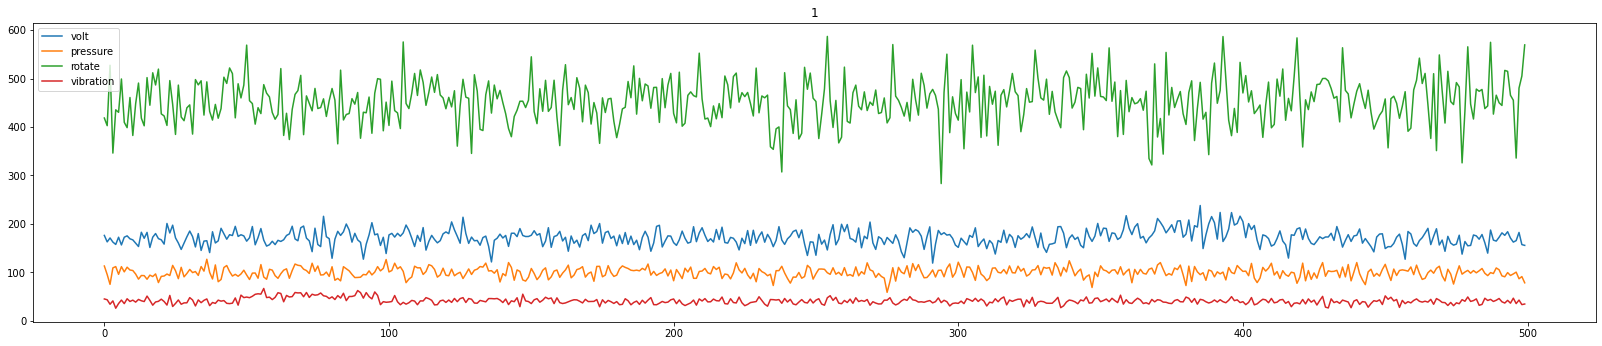

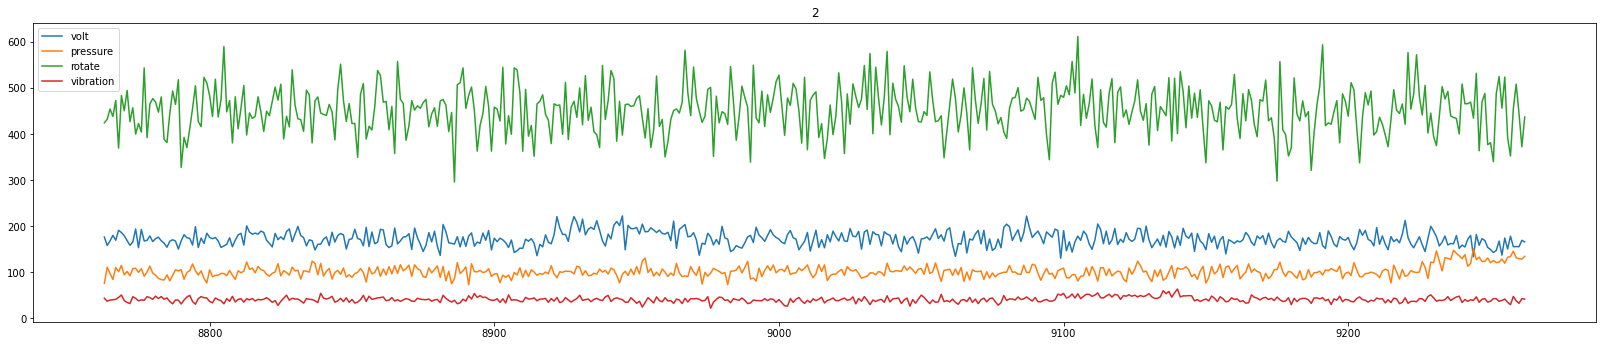

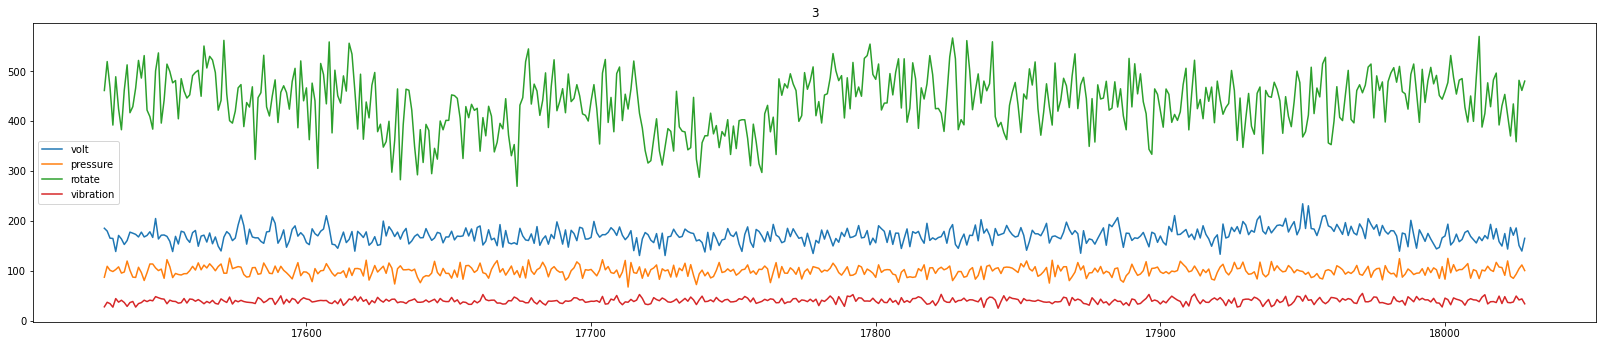

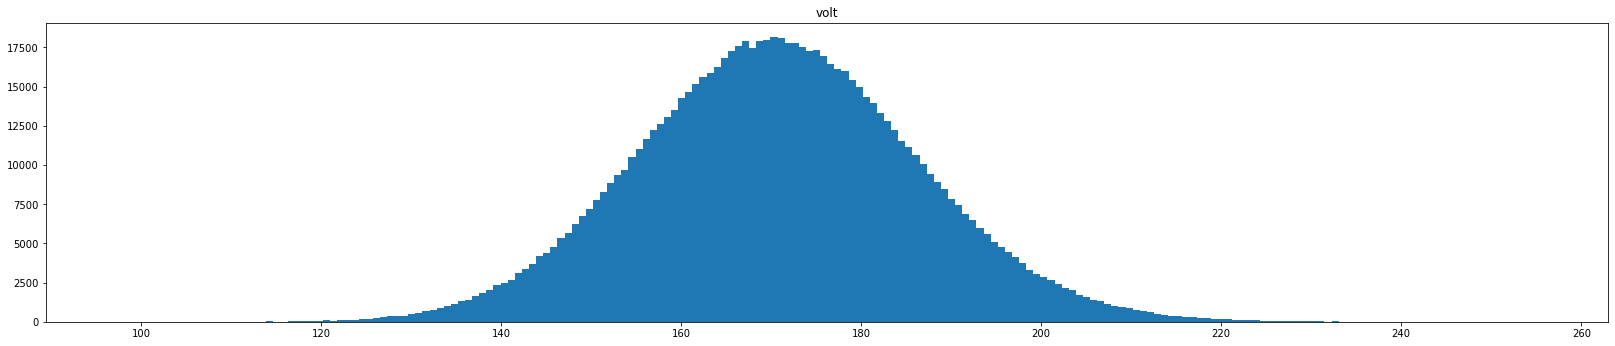

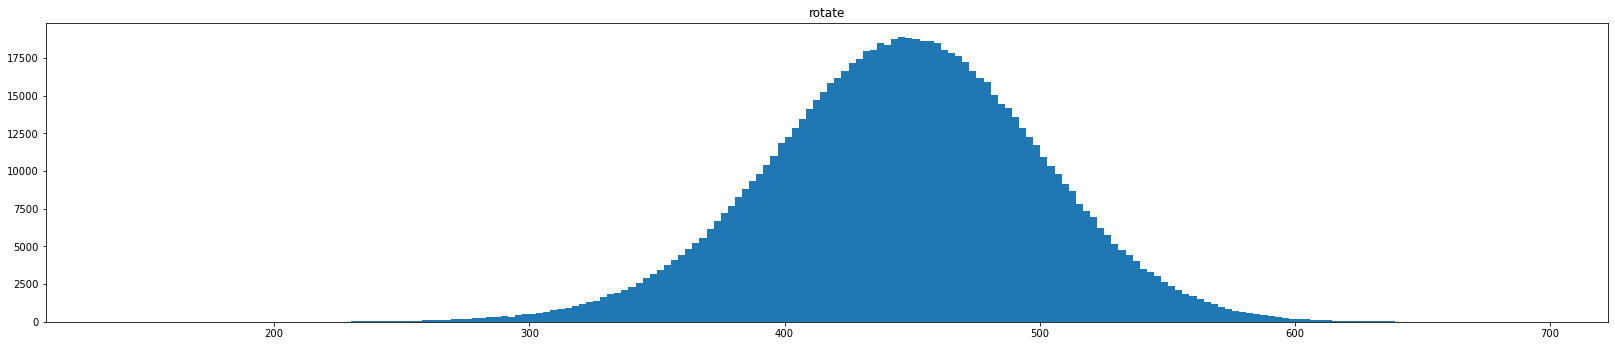

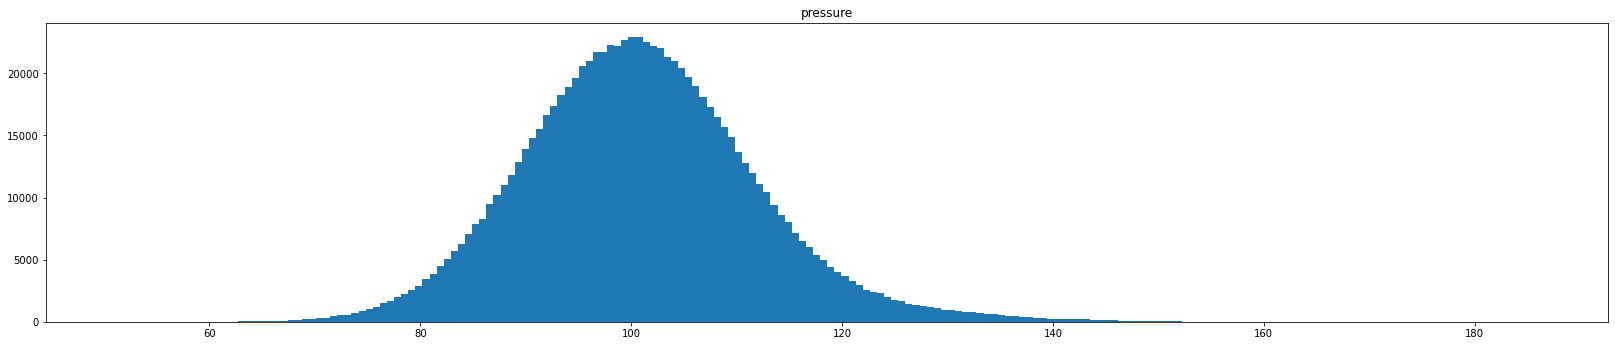

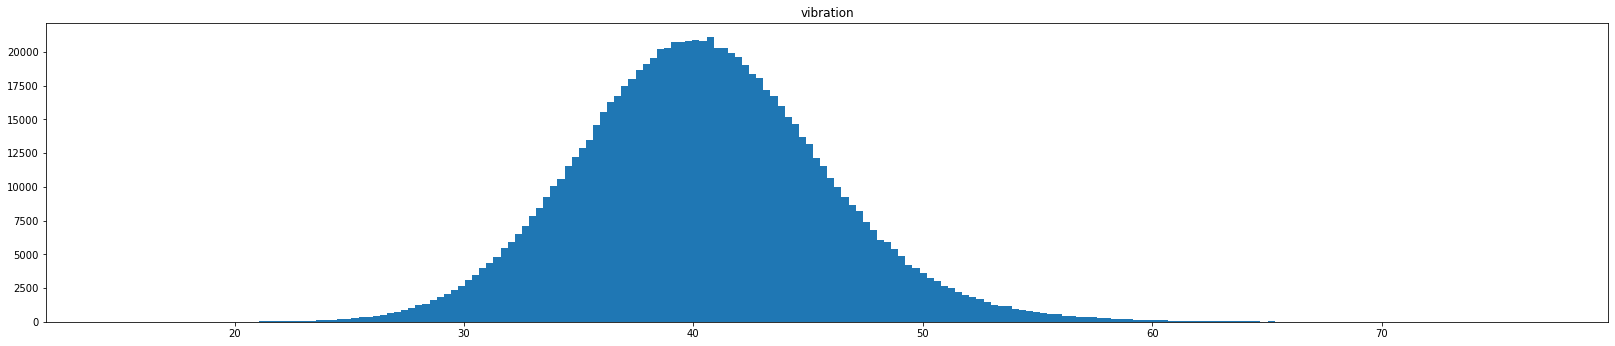

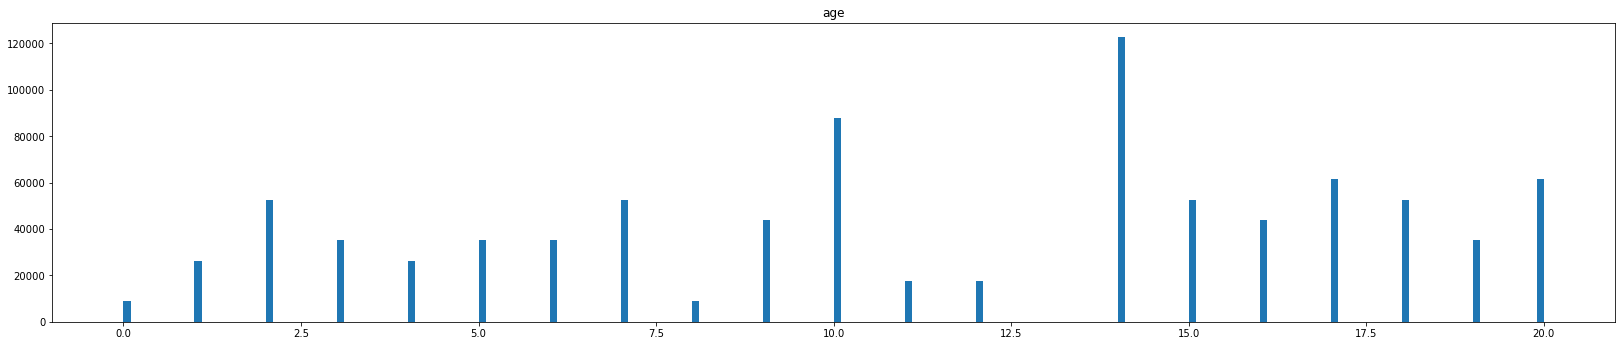

In [4]:
#'machineID', 'label', 'model', 'age', 'volt', 'rotate', 'pressure'
print("Discover what the data looks like for the first 100 transactions")
machineIds=[]
grouped=df.groupby('machineID')
for machineID in grouped:
    machineIds.append(machineID[0])

#print(machineIds)
plt.rcParams["figure.figsize"] = (28,5.5)
for machineId in machineIds[0:3]:
    #print(machineId)
    filter=df['machineID']==machineId
    results=df[filter][:500]
    #print(len(results))
    #print(results['datetime_x'])
    x=range(0,len(results)-1,1)
    plt.plot(results['volt'],label='volt')
    plt.plot(results['pressure'],label='pressure')
    plt.plot(results['rotate'],label='rotate')
    plt.plot(results['vibration'],label='vibration')
    #twin_ax=plt.twinx()
    #twin_ax.plot(results['age'],label='age')
    plt.title(machineId)
    plt.legend()
    plt.show()
    
columns=[column for column in df.columns if column in['age','vibration','rotate','pressure','volt']]
for column in columns:
    plt.hist(df[column],bins=200)
    plt.title(column)
    plt.show()



In [5]:
print("Drop non contributing features and dummy the multi-class output")
if "datetime" in df:
    df.drop(["Unnamed: 0_x","Unnamed: 0_y","datetime","failure"],axis=1,inplace=True)
    df.rename(columns={"errorID":"label"},inplace=True)

failure_types=set(df['label'])
print(failure_types)

encoder=LabelEncoder()
df['label']=encoder.fit_transform(df['label'])
df['model']=encoder.fit_transform(df['model'])

X_columns=[x for x in df.columns if x!='label']

X=df[X_columns]
y=df['label']
#y = np.asarray(y).astype(np.float32)
y = pd.get_dummies(y)

print(y)

print(df.columns)
print(df.head(1))

Drop non contributing features and dummy the multi-class output
{nan, 'error5', 'error4', 'error3', 'error2', 'error1'}
        0  1  2  3  4  5
0       0  0  0  0  0  1
1       0  0  0  0  0  1
2       0  0  0  0  0  1
3       0  0  0  0  0  1
4       0  0  0  0  0  1
...    .. .. .. .. .. ..
876440  0  0  0  0  0  1
876441  0  0  0  0  0  1
876442  0  0  0  0  0  1
876443  0  0  0  0  0  1
876444  0  0  0  0  0  1

[876445 rows x 6 columns]
Index(['machineID', 'volt', 'rotate', 'pressure', 'vibration', 'label',
       'model', 'age'],
      dtype='object')
   machineID        volt      rotate    pressure  vibration  label  model  age
0          1  176.217853  418.504078  113.077935  45.087686      5      2   18


In [6]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.33, random_state=42)

print(X_train.columns)
print("rows",X_train.shape[0],"columns",X_train.shape[1])
print((X_train.shape[0],X_train.shape[1],1))

Index(['machineID', 'volt', 'rotate', 'pressure', 'vibration', 'model', 'age'], dtype='object')
rows 587218 columns 7
(587218, 7, 1)


In [ ]:
#for index, item in enumerate(y_train.values):
#    if ((item[0]==0) and (item[1]==0) and (item[2]==0) and (item[3]==0)):
#        print(item)


In [14]:
activation2="relu"
batch_size=64
look_back=1
features=len(X_columns)
print("build the Dense model")
model = Sequential()
features=len(X_columns)
model.add(LSTM(units=256, activation='relu', input_shape=(look_back, features),dtype="float32"))
model.add(Dropout(0.2))
model.add(Dense(units=250, activation=activation2))
model.add(Dense(units=250, activation=activation2))
model.add(Dense(units=250, activation=activation2))
model.add(Dense(units=250, activation=activation2))
model.add(Dense(units=250, activation=activation2))
model.add(Flatten())
model.add(Dense(len(y_train.columns),activation='softmax'))
model.compile(optimizer="rmsprop", loss='categorical_crossentropy', metrics=['accuracy'])

build the Dense model


In [15]:
print("X train shape",X_train.shape)
#print(X_train)
print("y train shape",y_train.shape)


X train shape (587218, 7)
y train shape (587218, 6)


Train the model
23000 33000


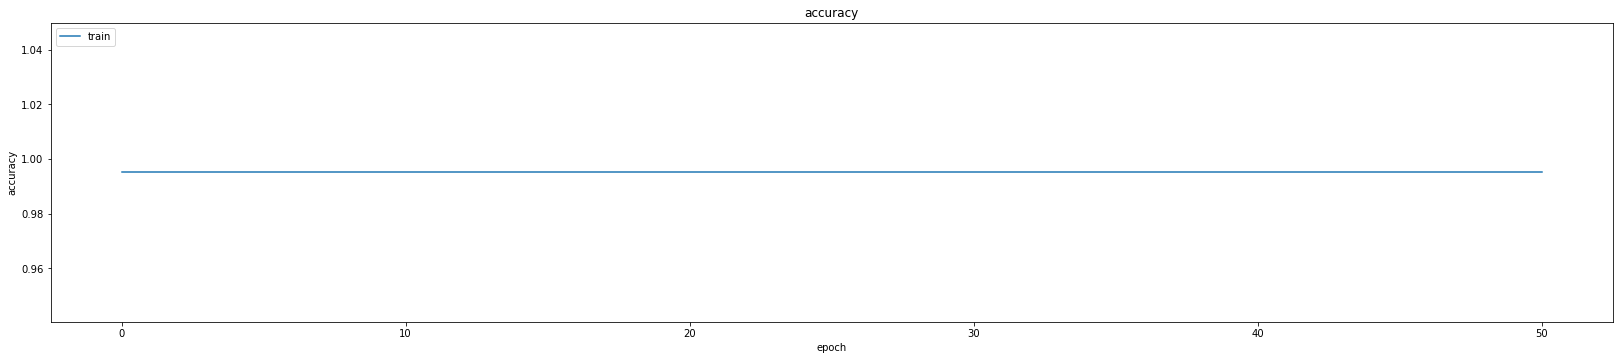

33000 43000


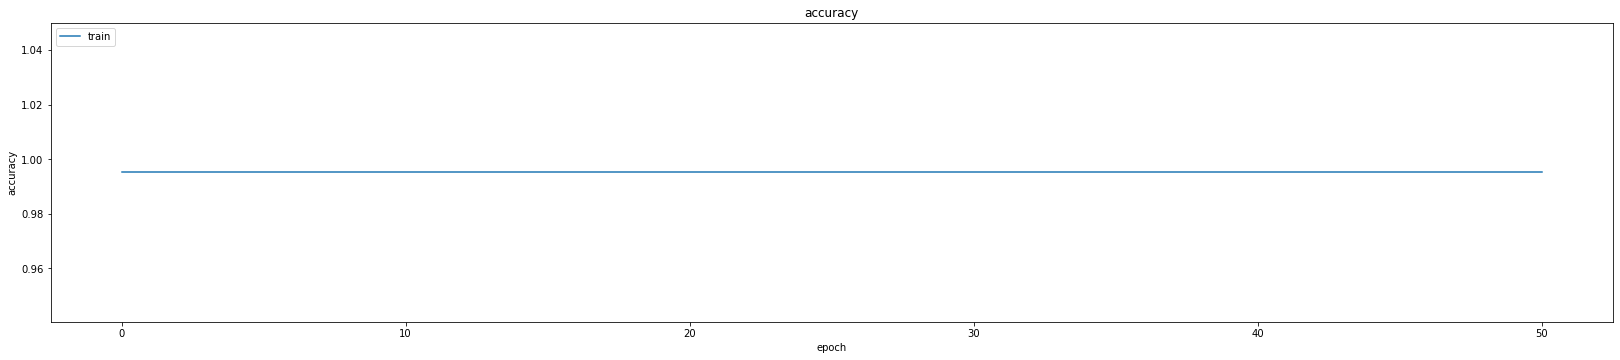

43000 53000


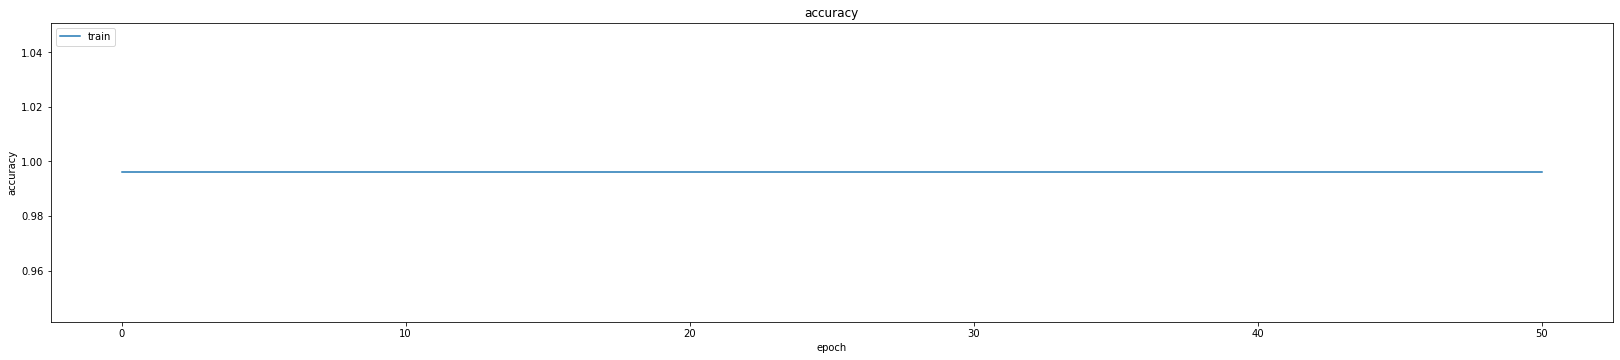

53000 63000


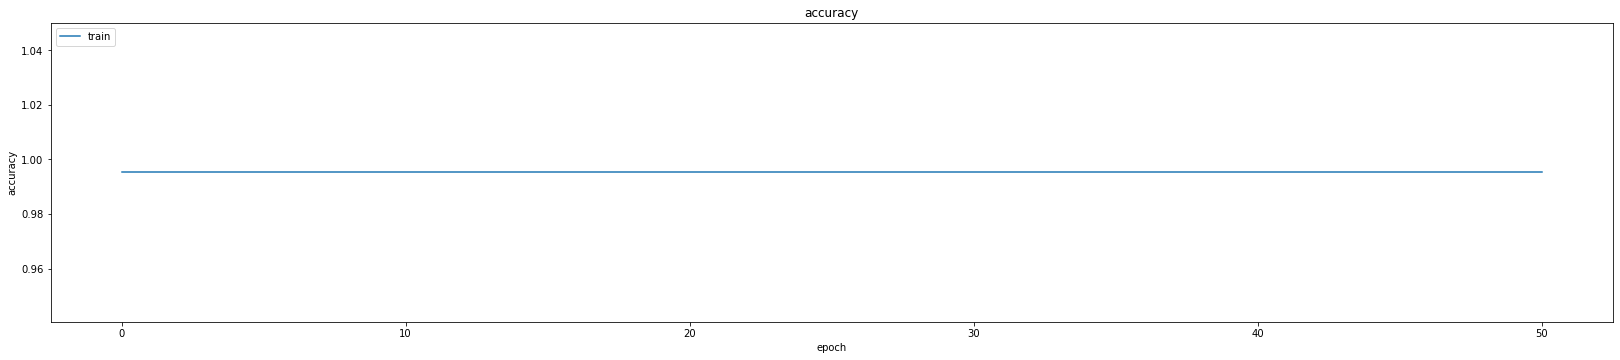

63000 73000


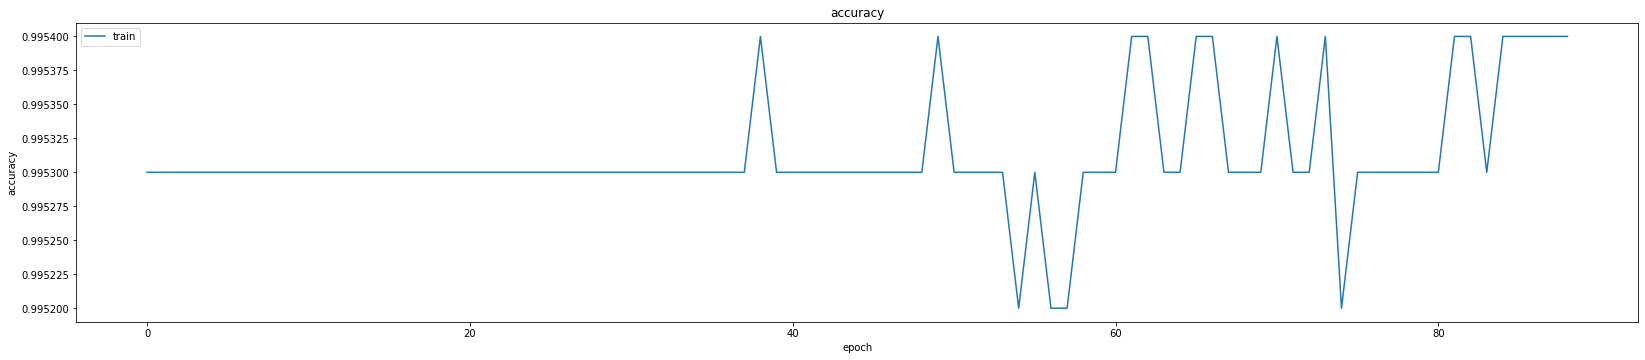

73000 83000


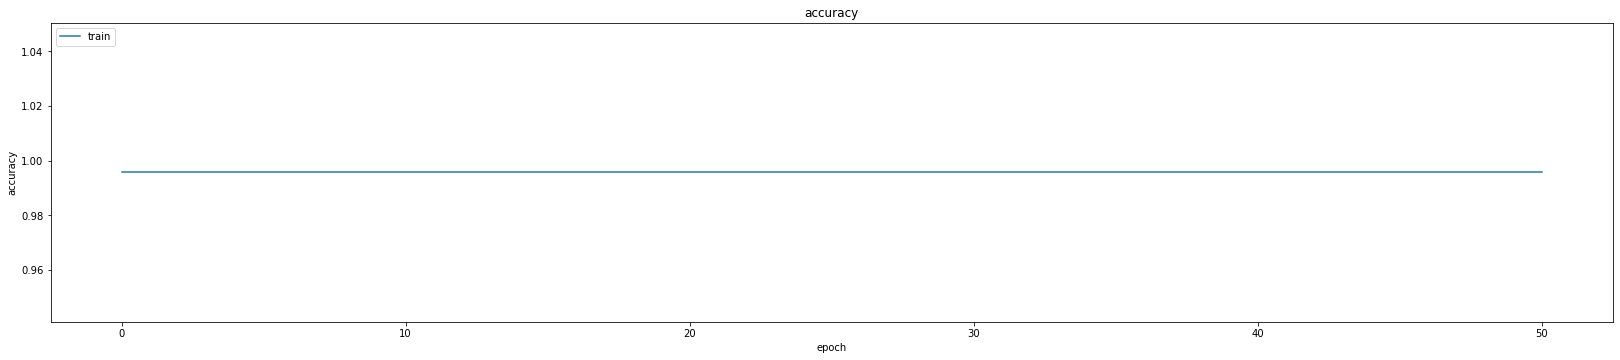

83000 93000


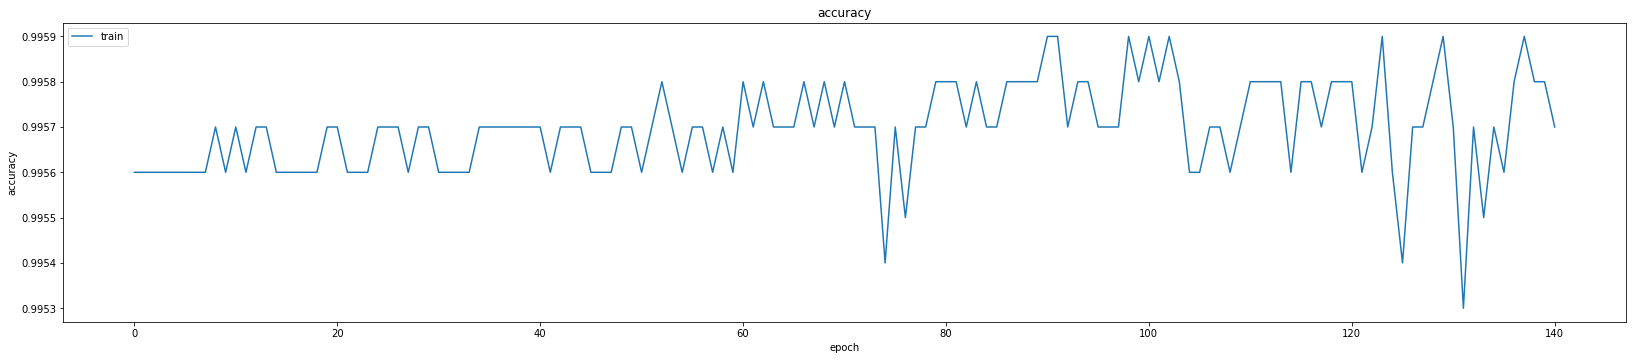

93000 103000


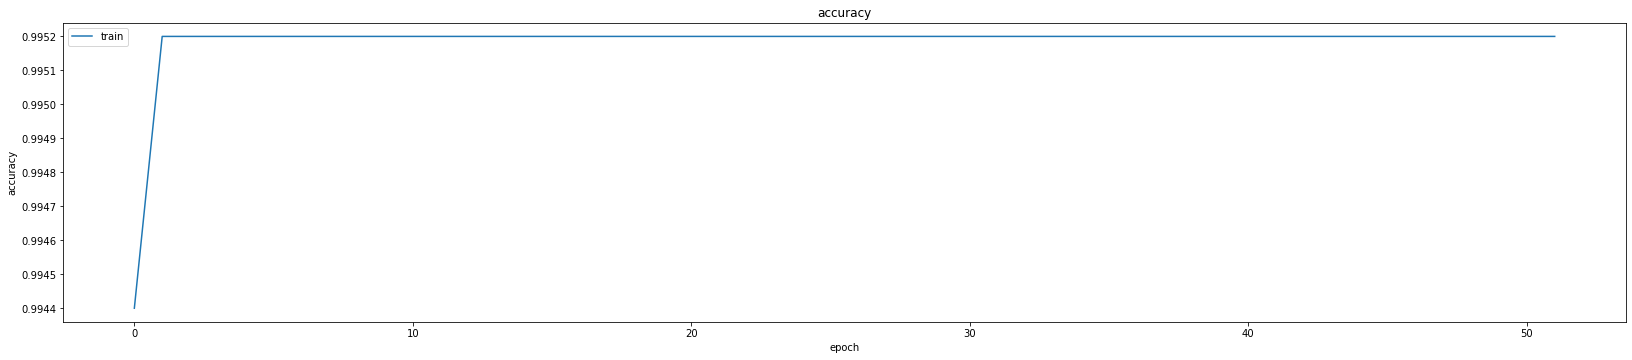

103000 113000


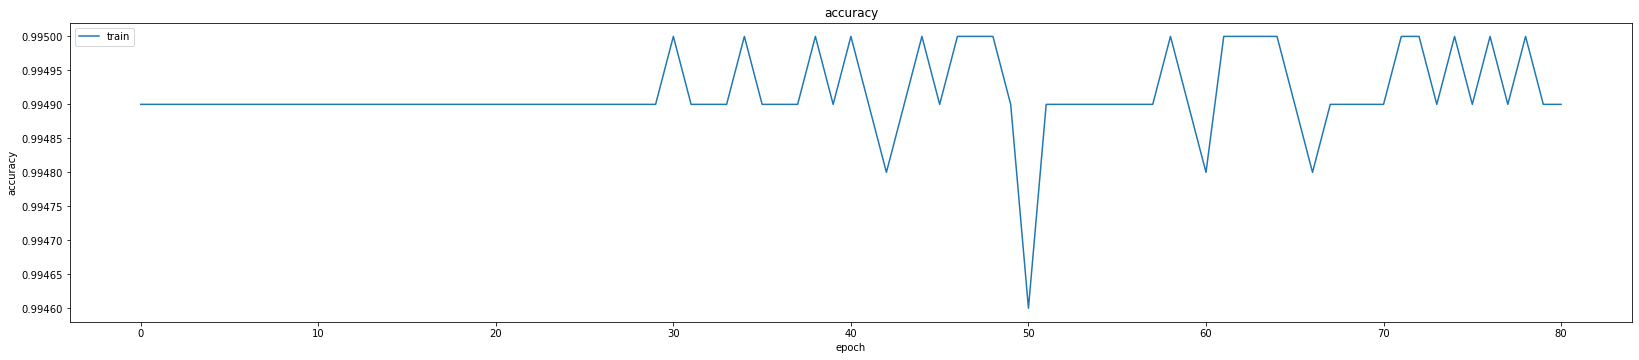

113000 123000


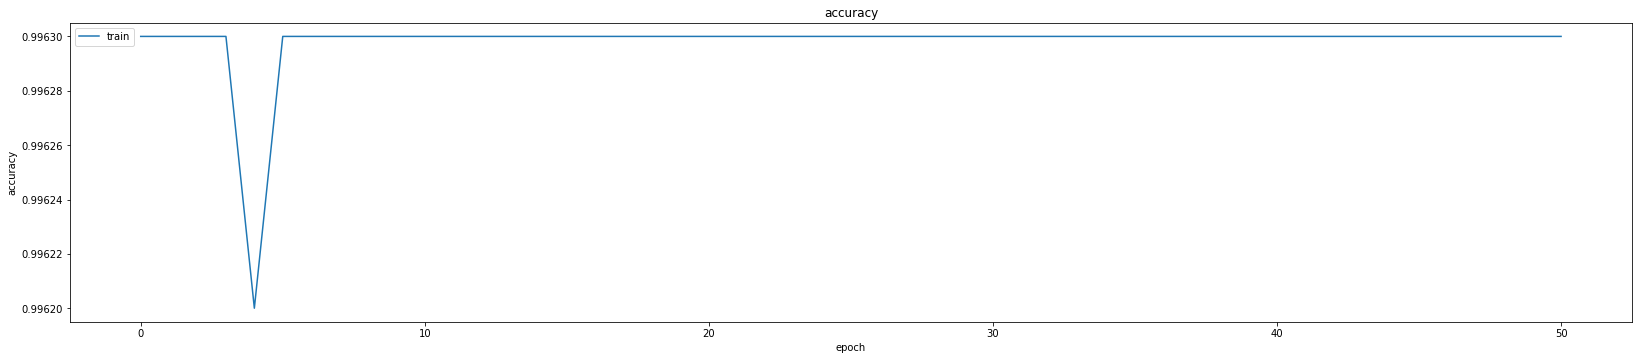

123000 133000


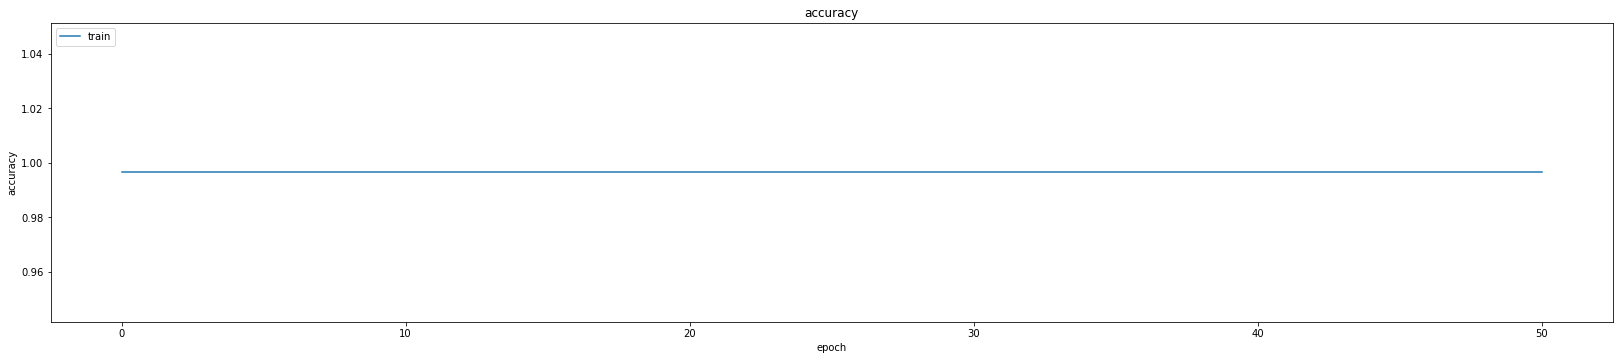

133000 143000


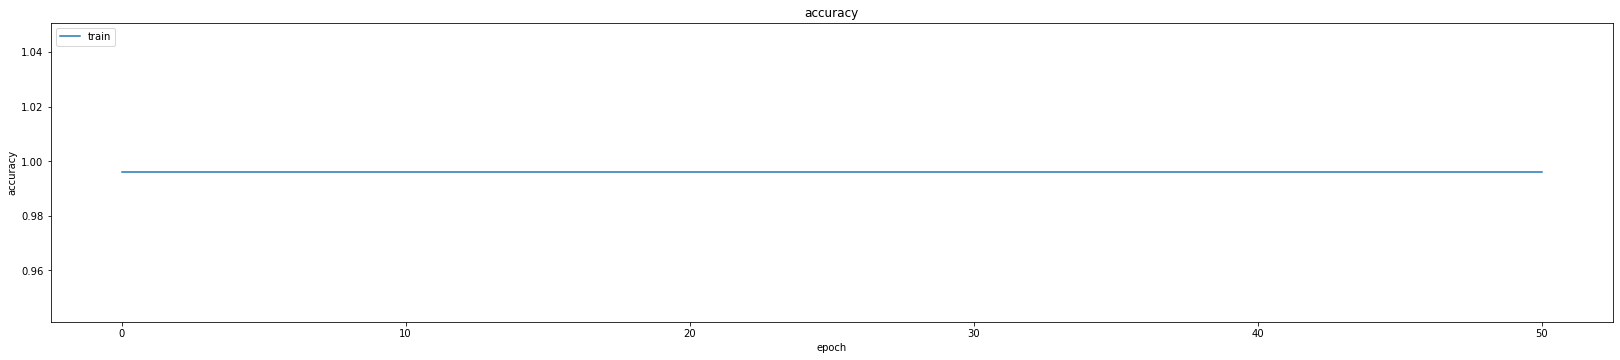

143000 153000


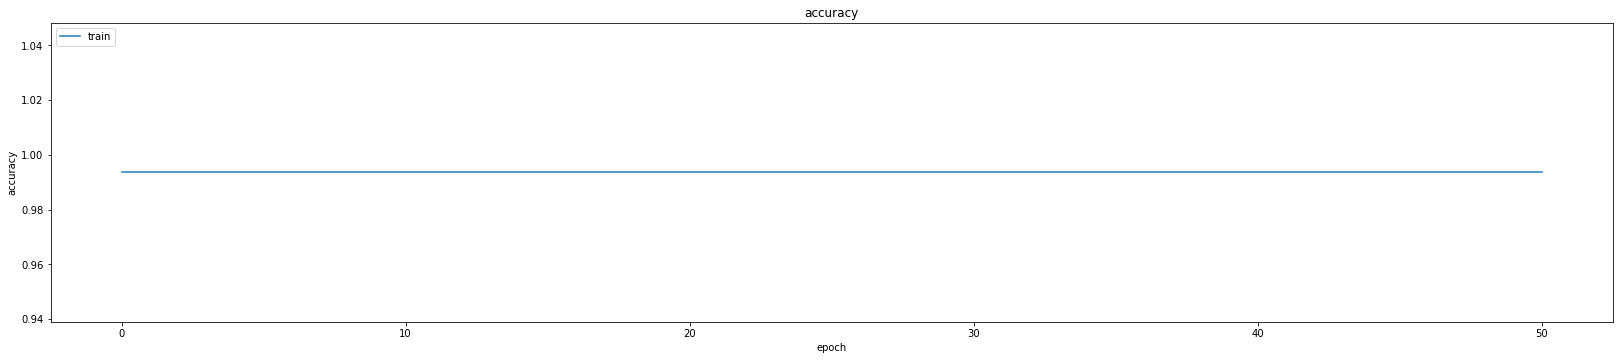

153000 163000


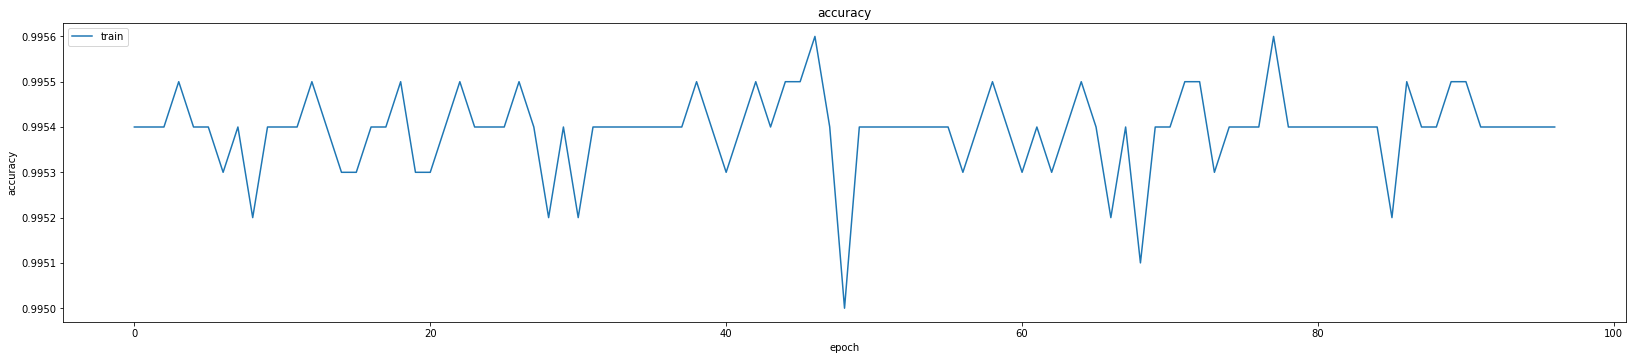

163000 173000


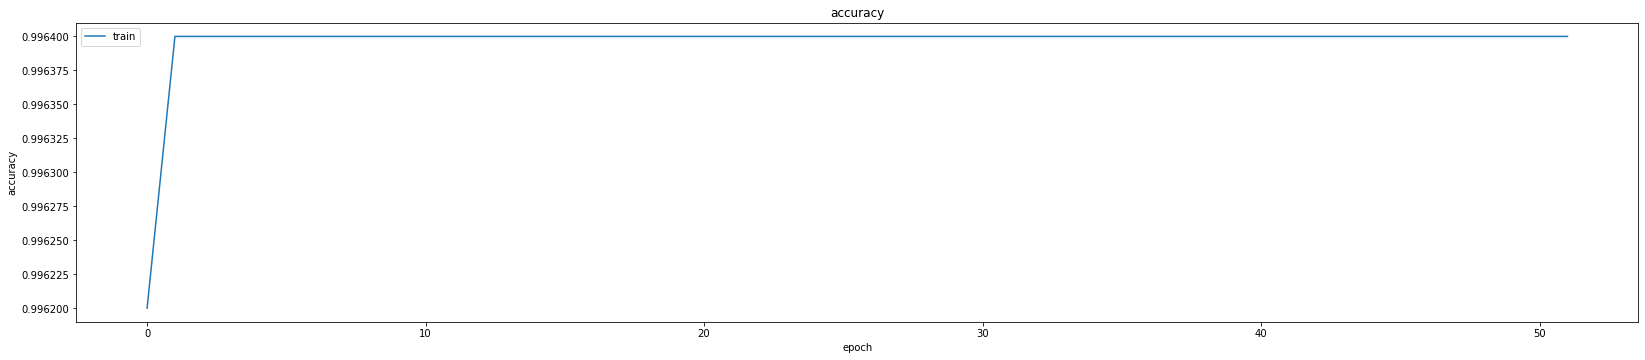

173000 183000


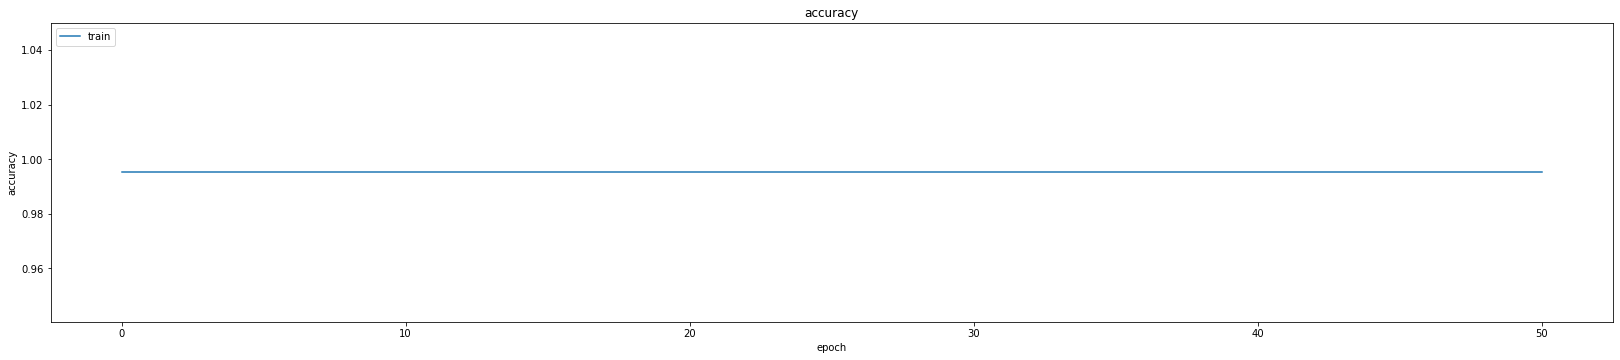

183000 193000


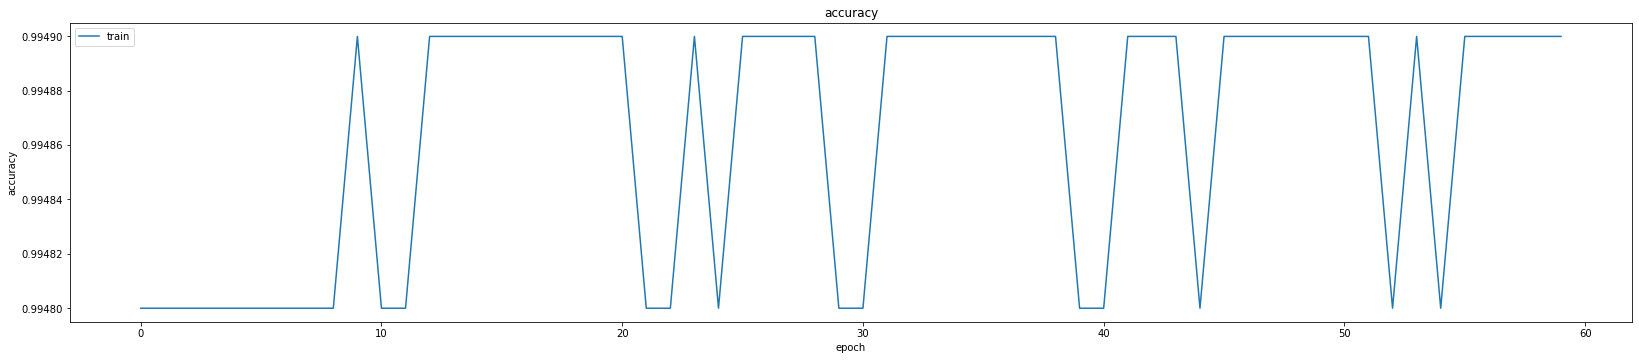

193000 203000


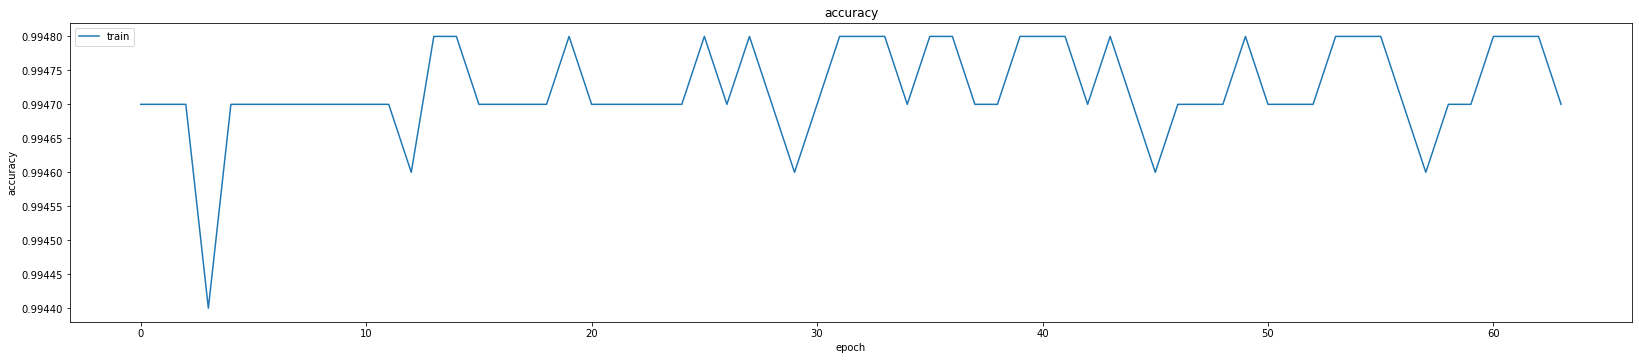

203000 213000


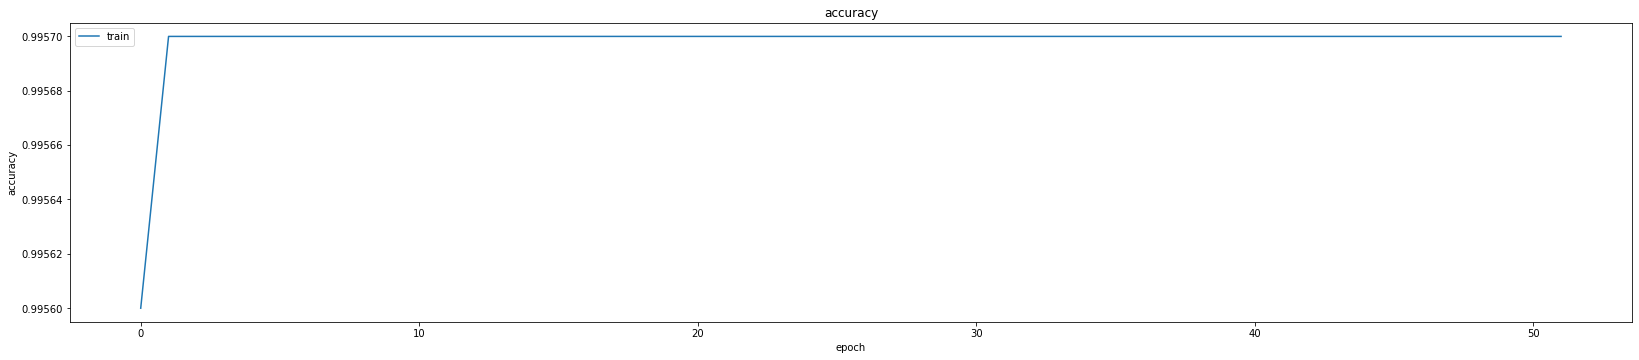

213000 223000


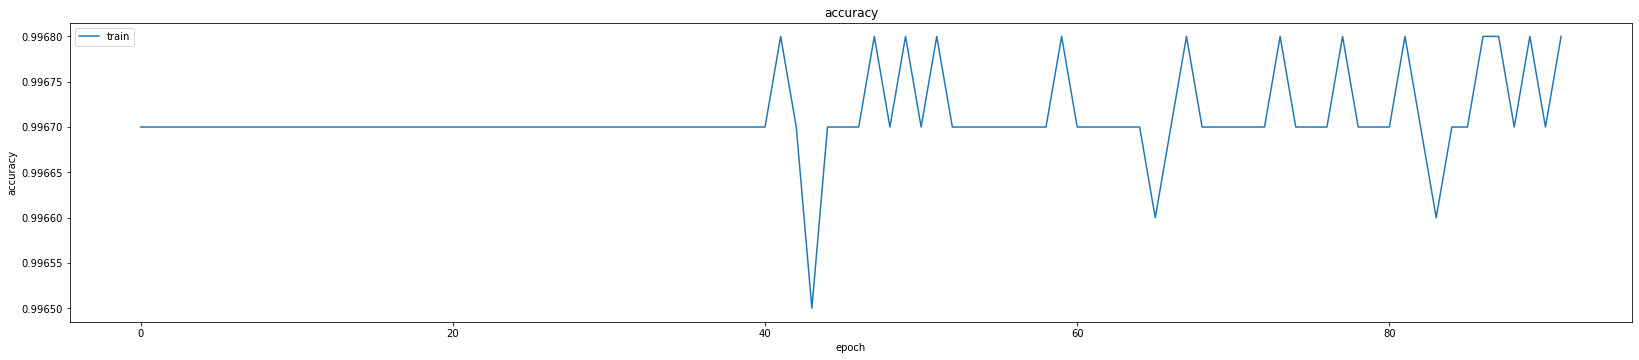

223000 233000


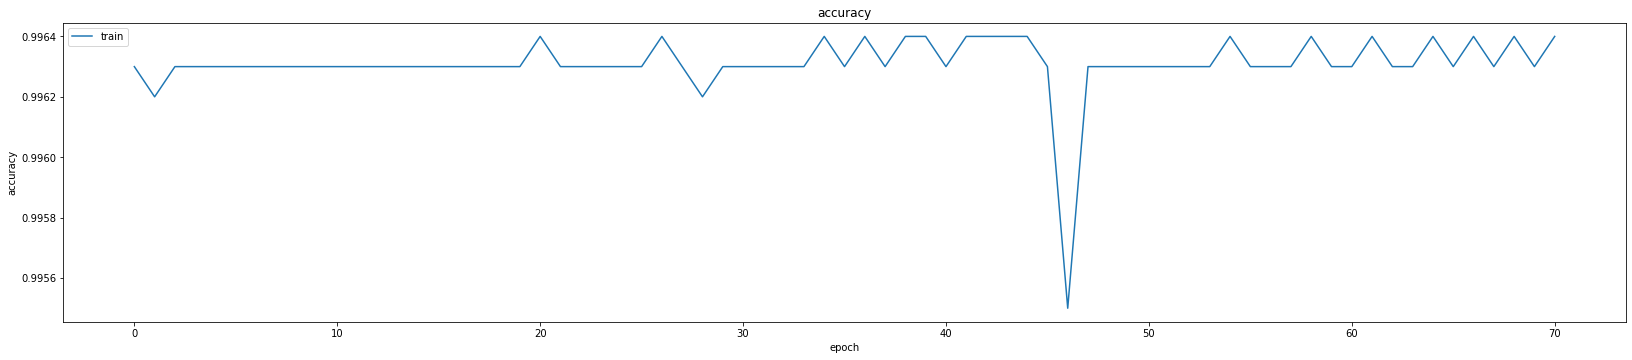

233000 243000


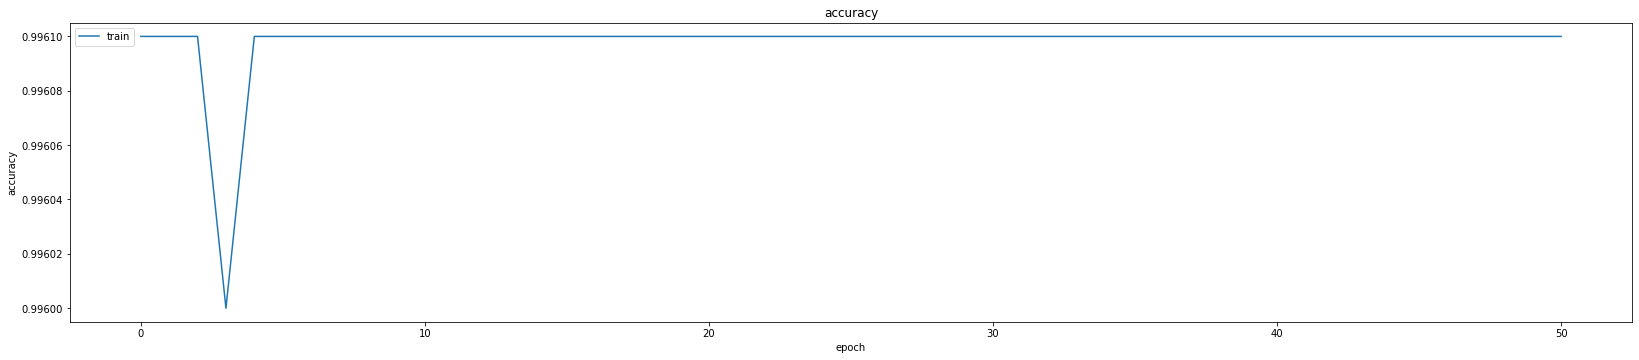

243000 253000


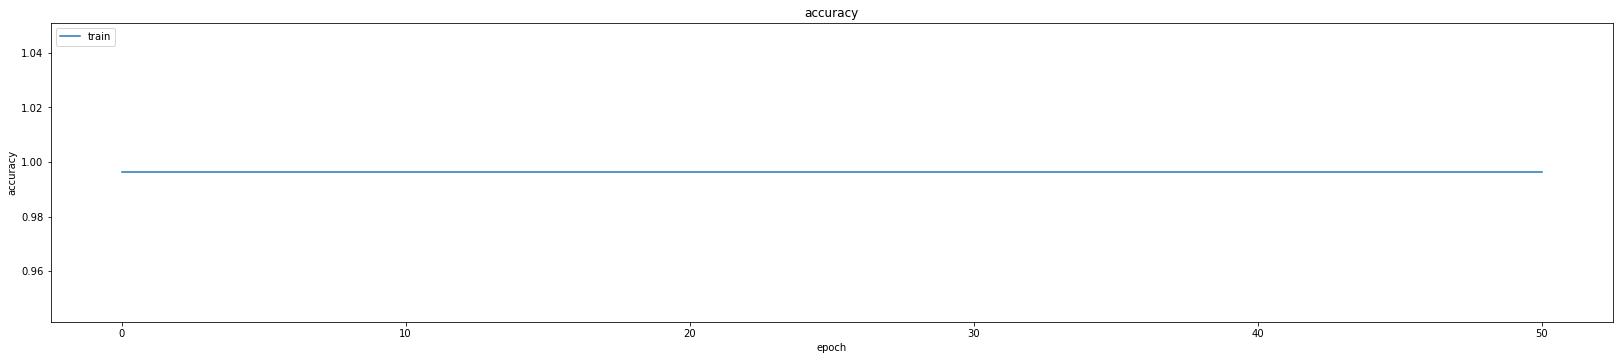

253000 263000


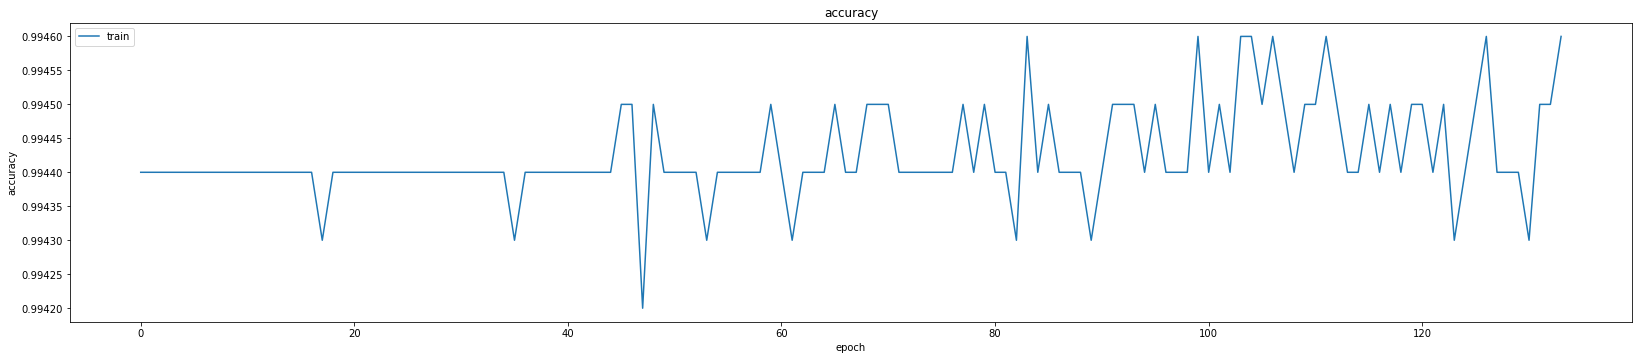

263000 273000


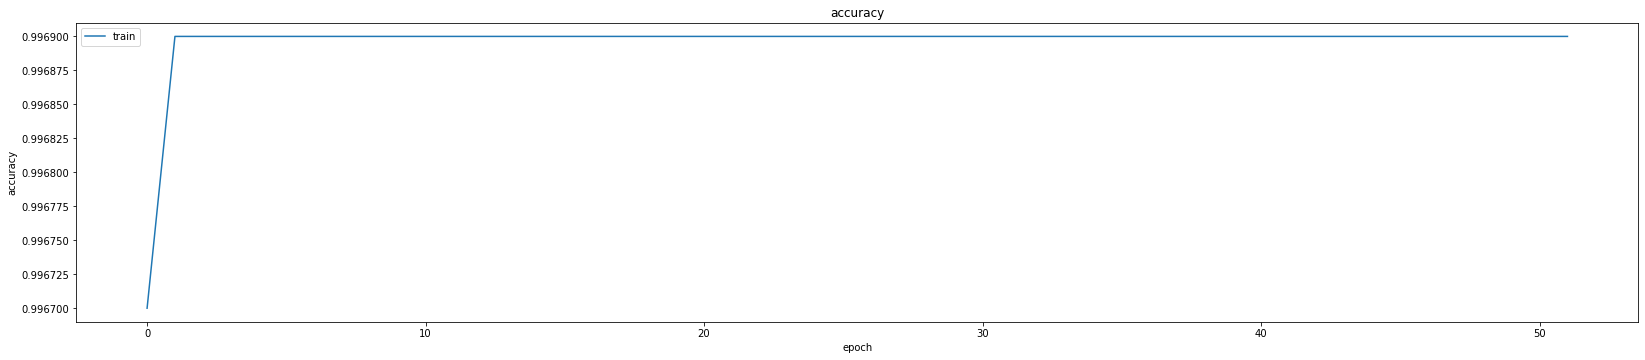

273000 283000


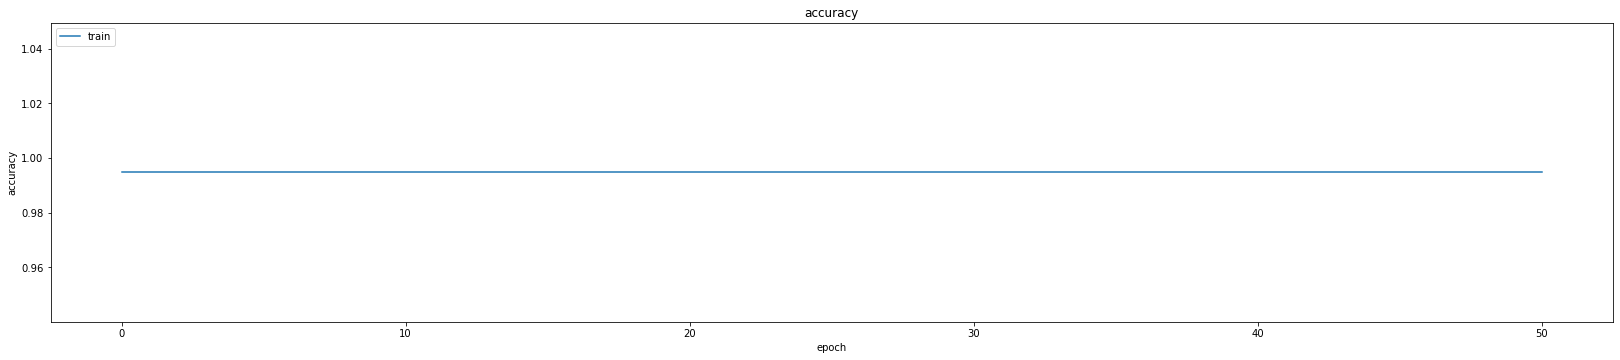

283000 293000


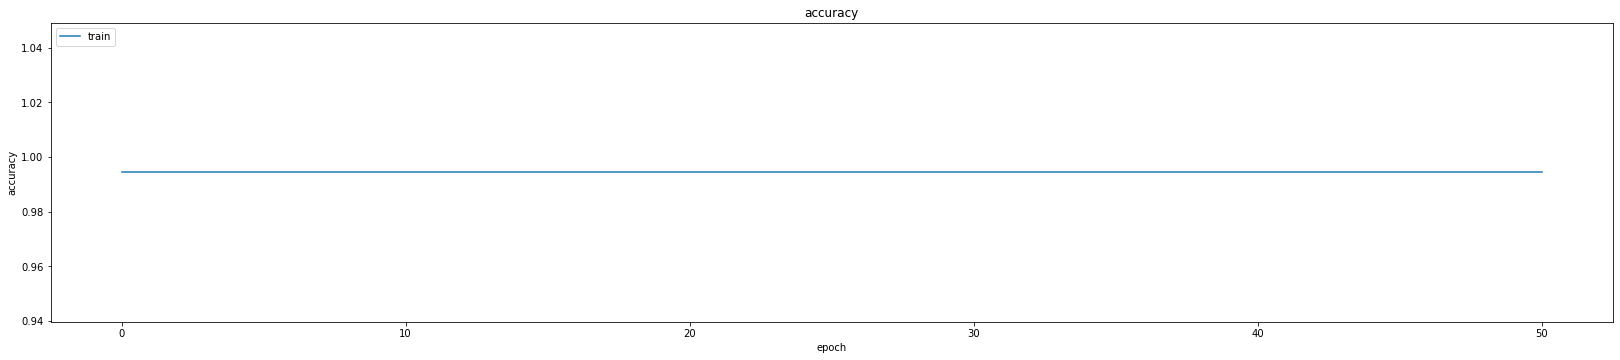

293000 303000


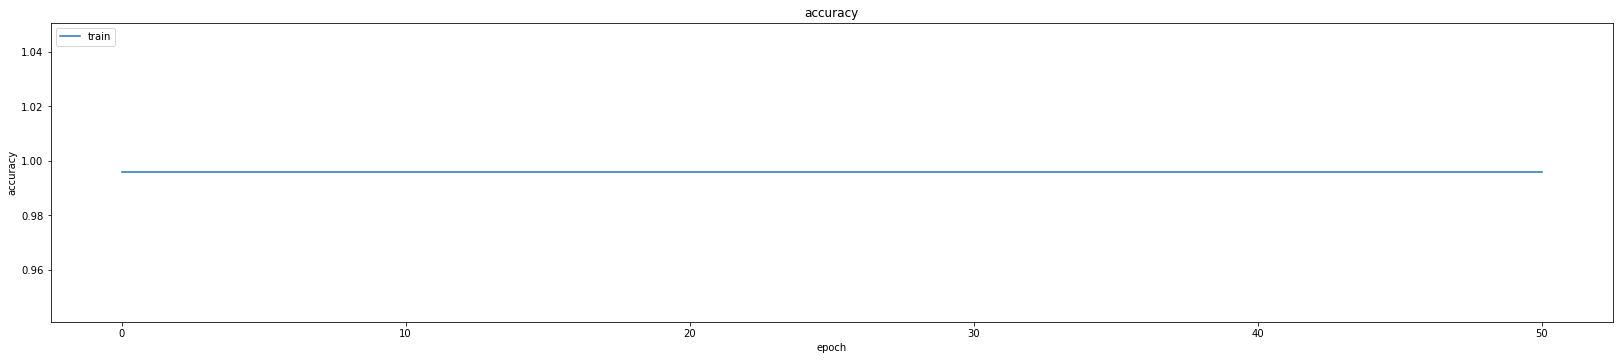

303000 313000


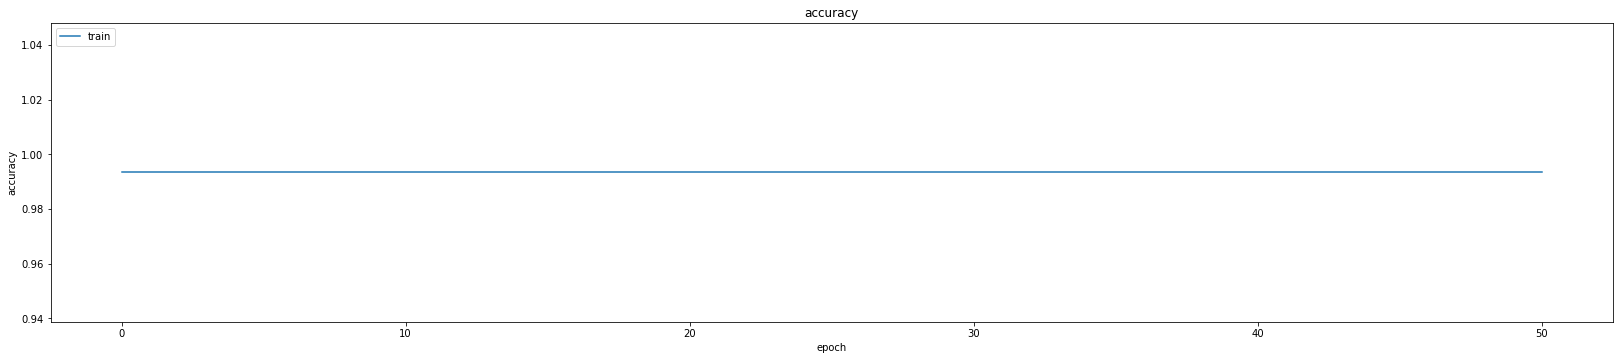

313000 323000


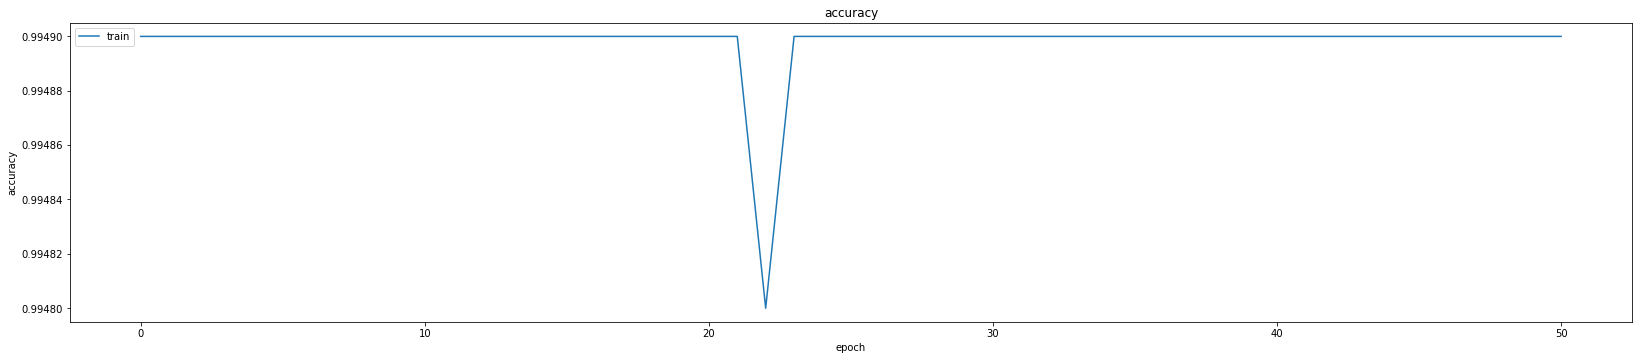

323000 333000


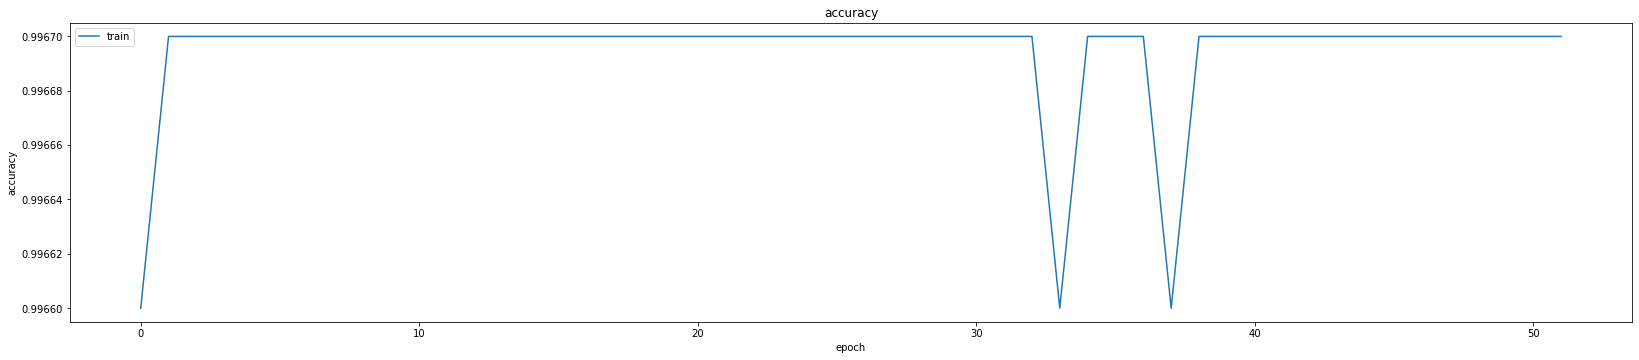

333000 343000


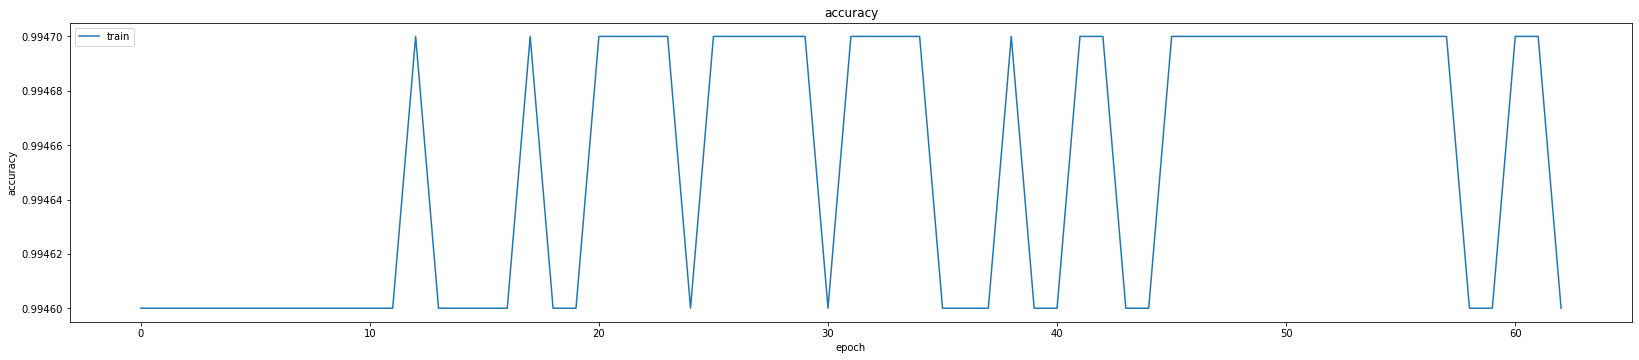

343000 353000


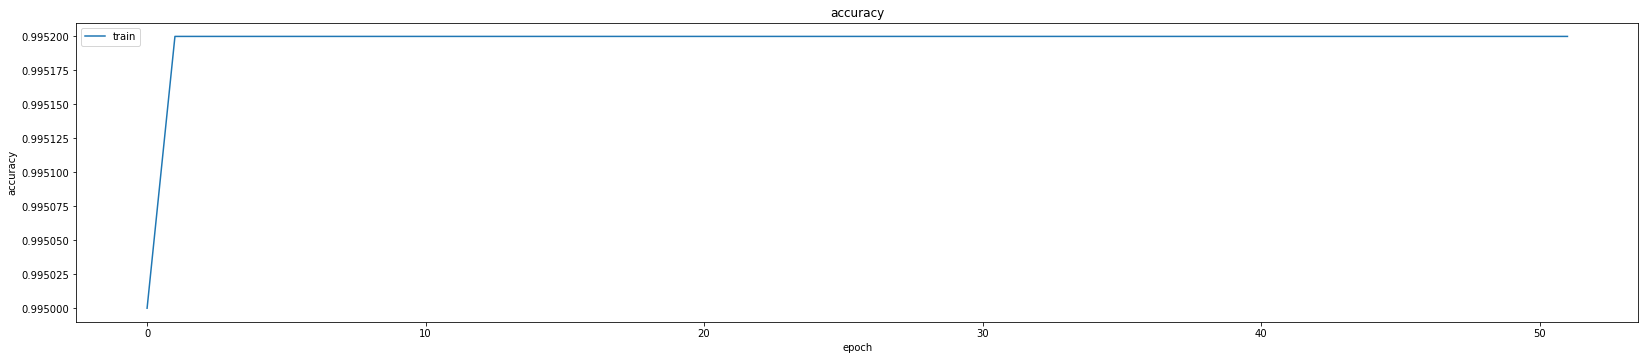

353000 363000


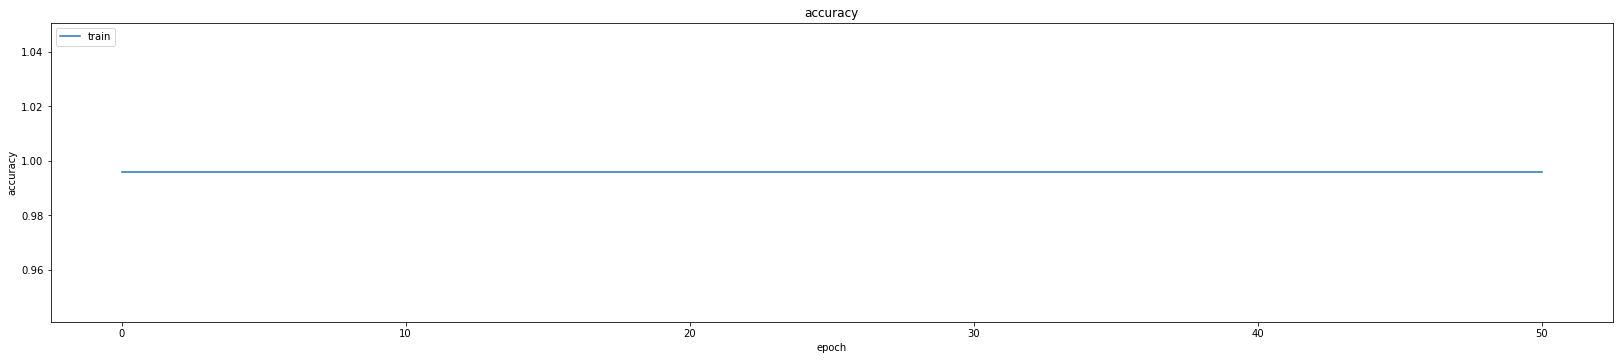

363000 373000


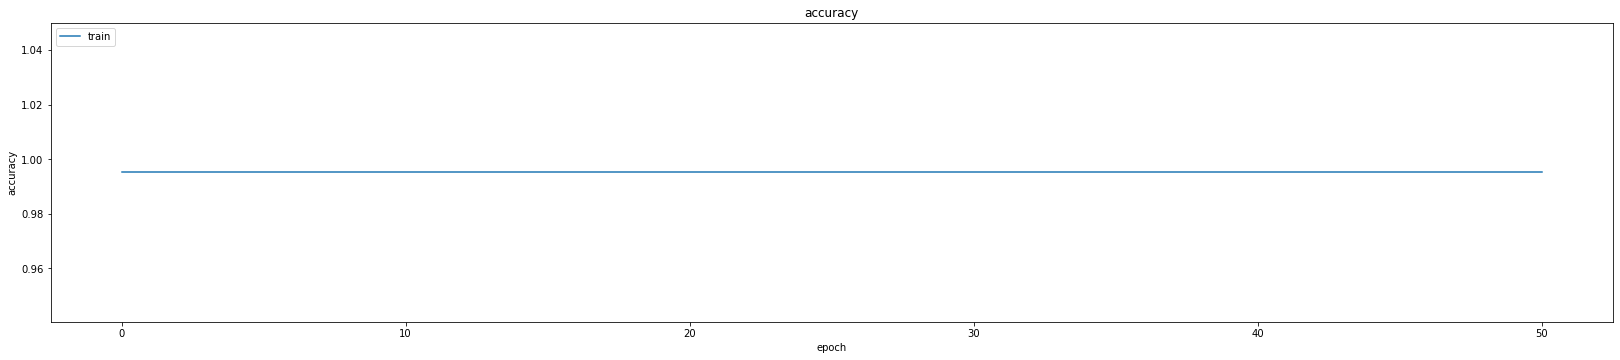

373000 383000


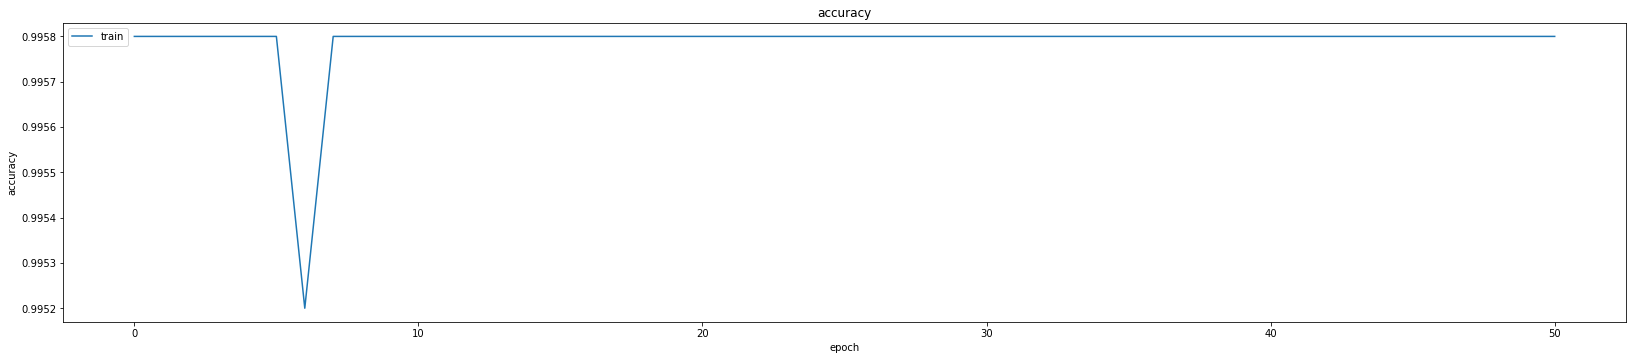

383000 393000


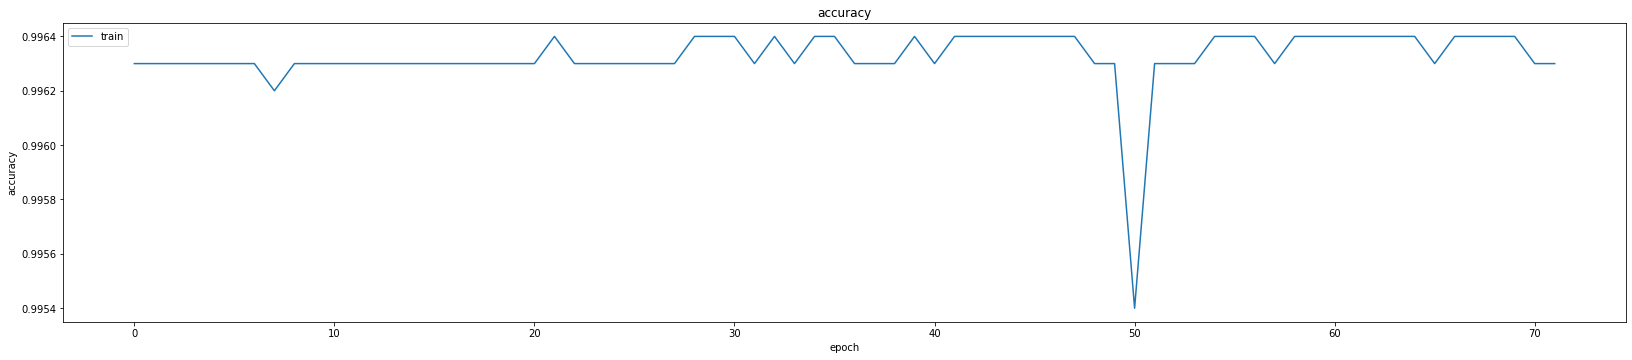

393000 403000


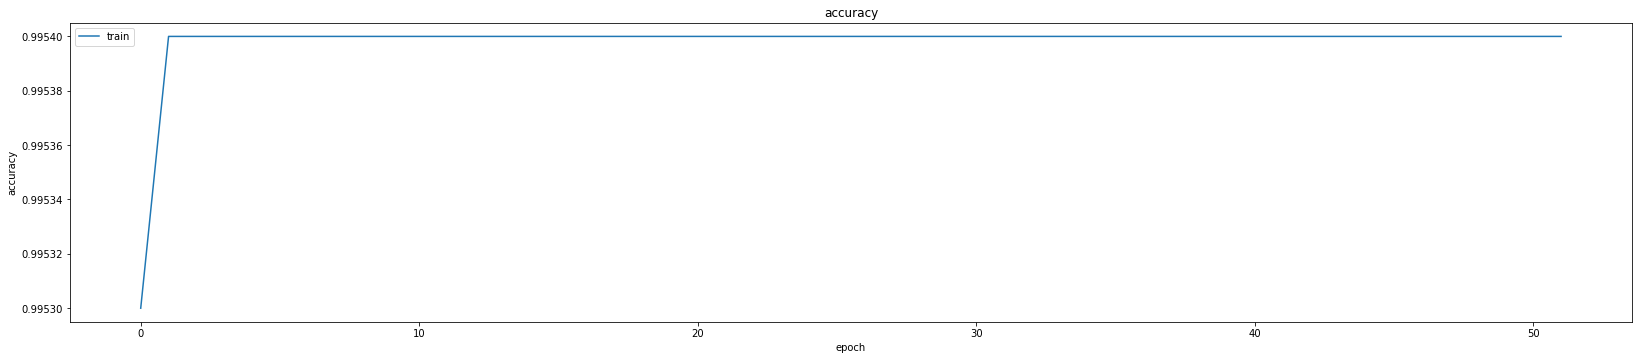

403000 413000


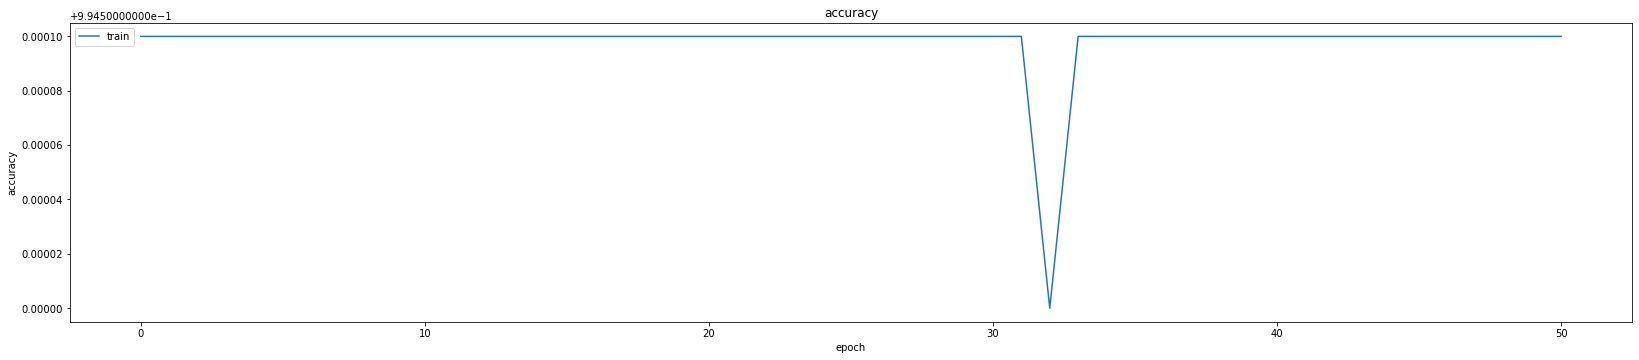

413000 423000


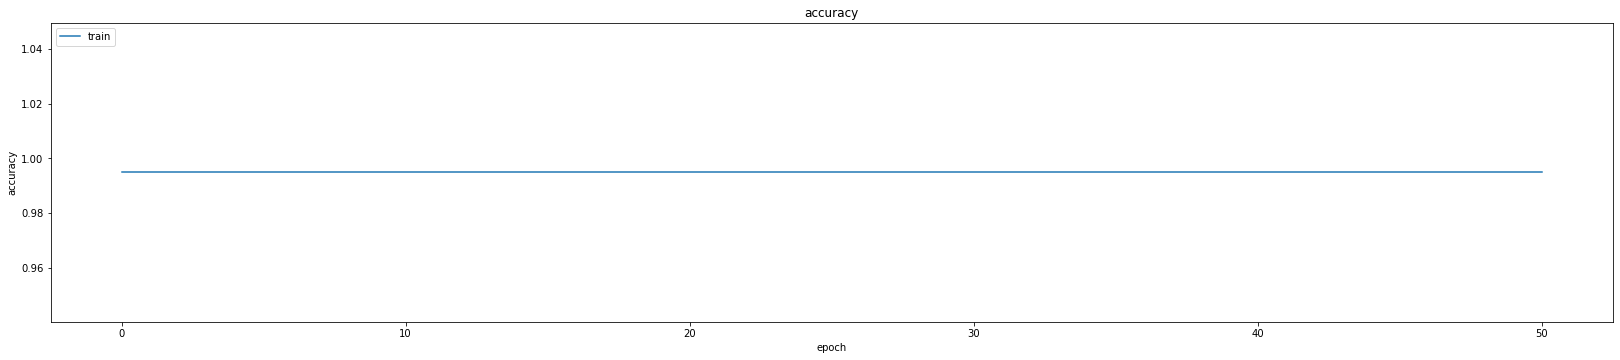

423000 433000


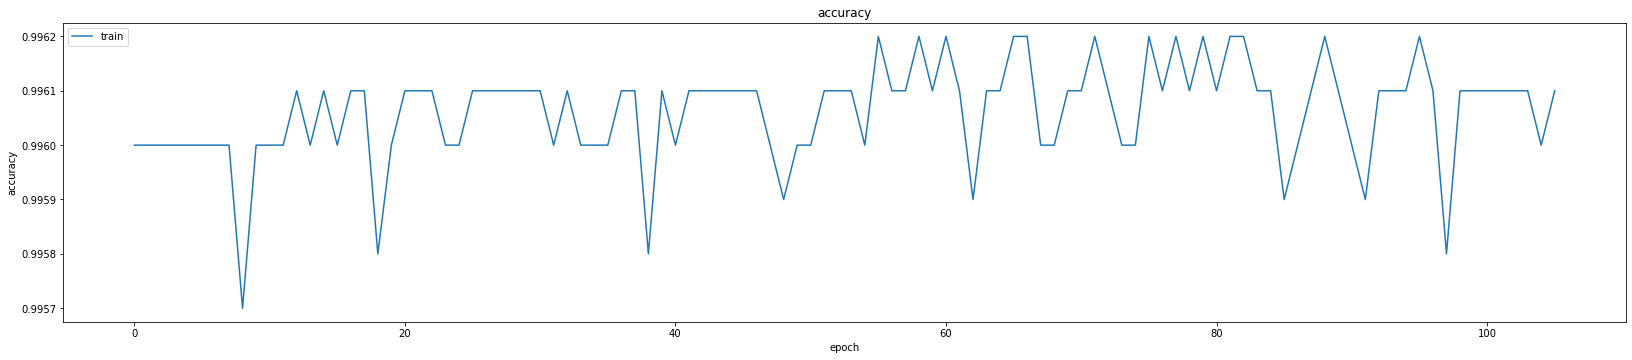

433000 443000


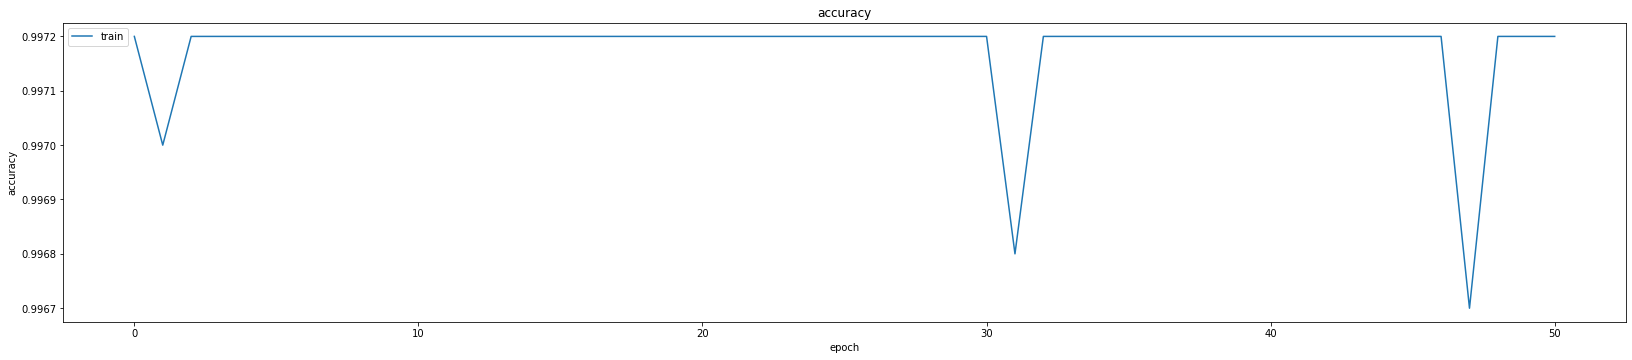

443000 453000


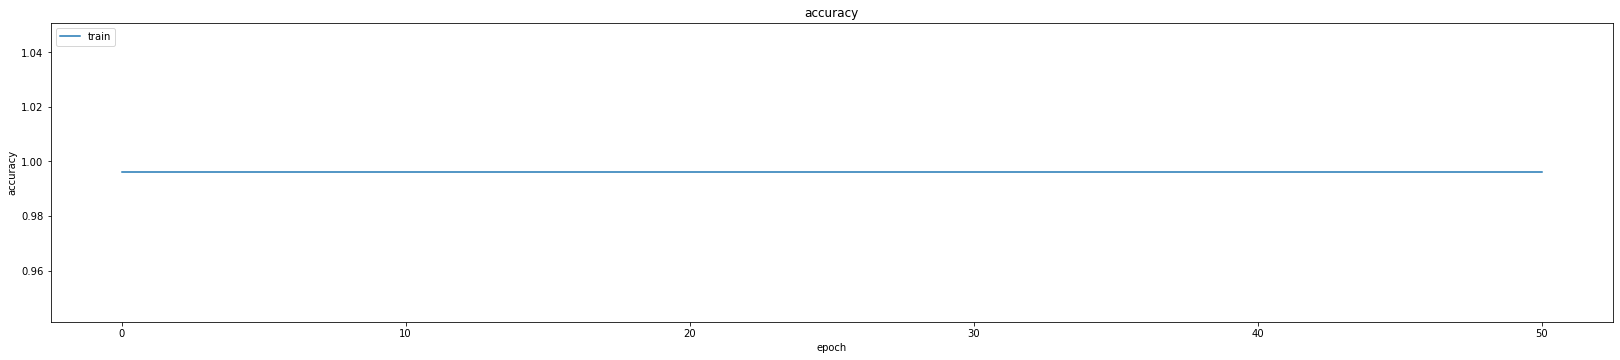

453000 463000


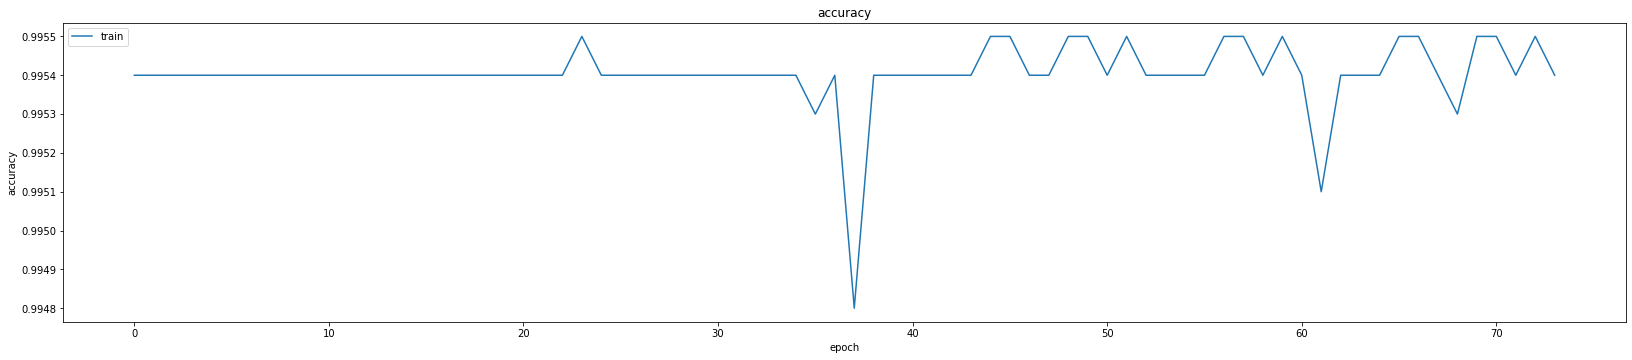

463000 473000


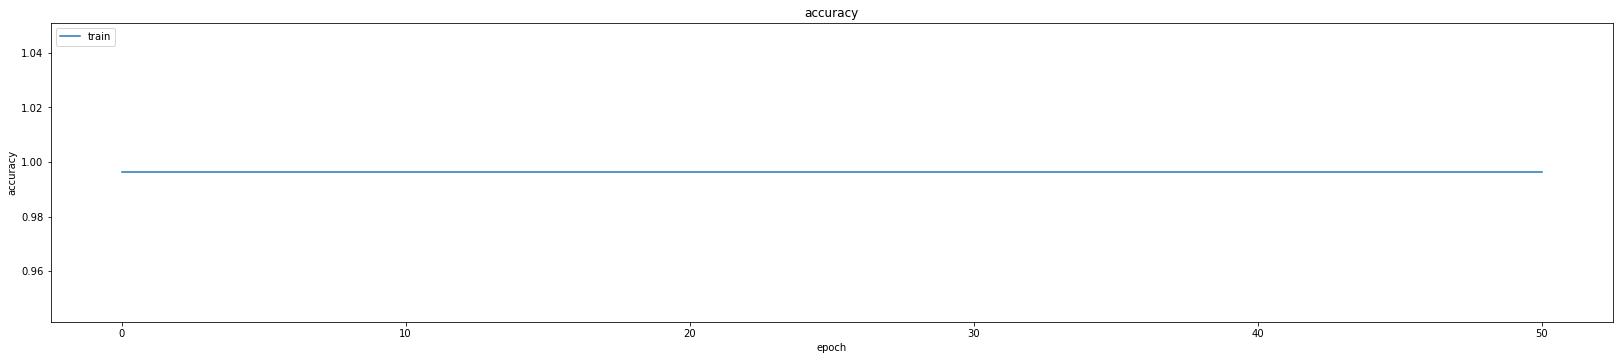

473000 483000


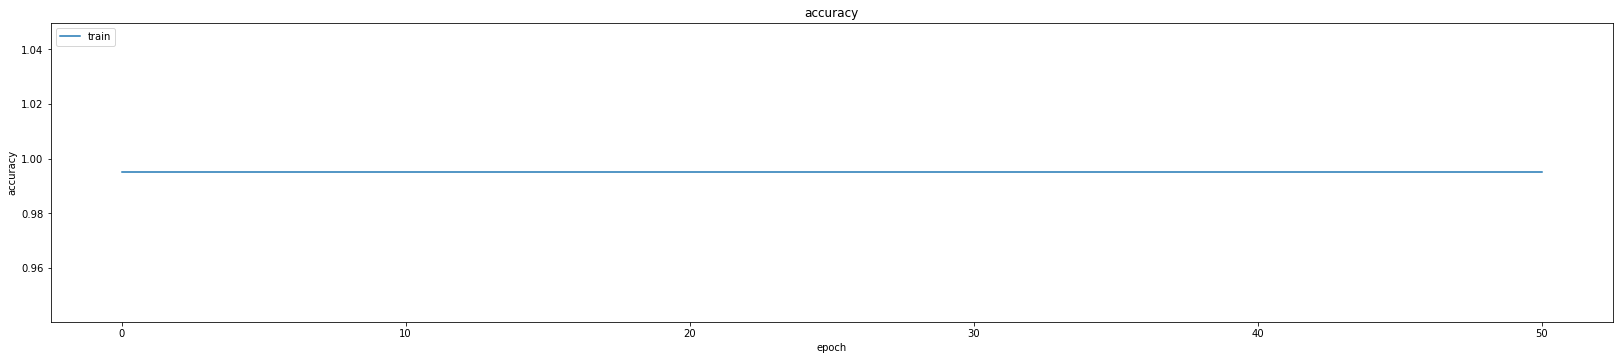

483000 493000


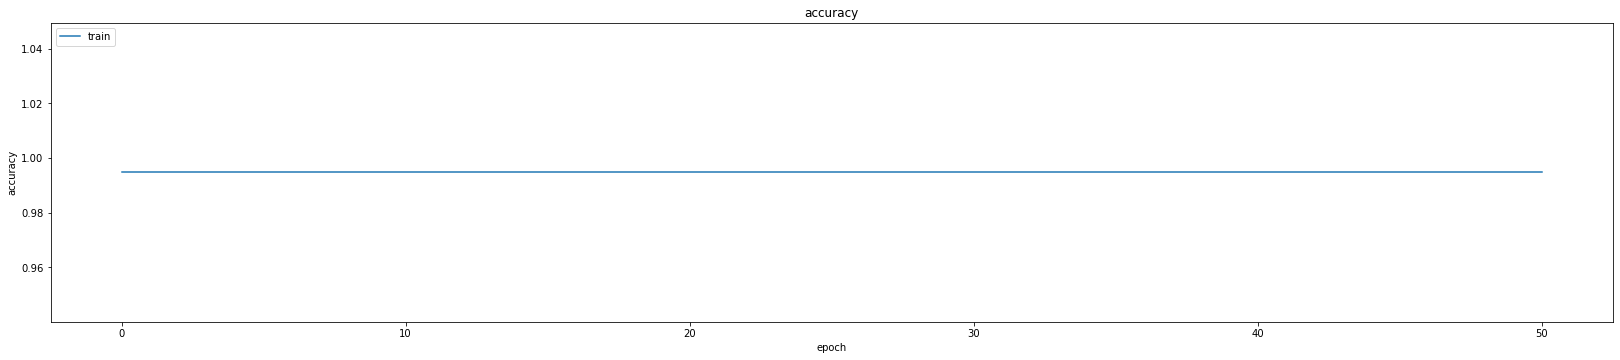

493000 503000


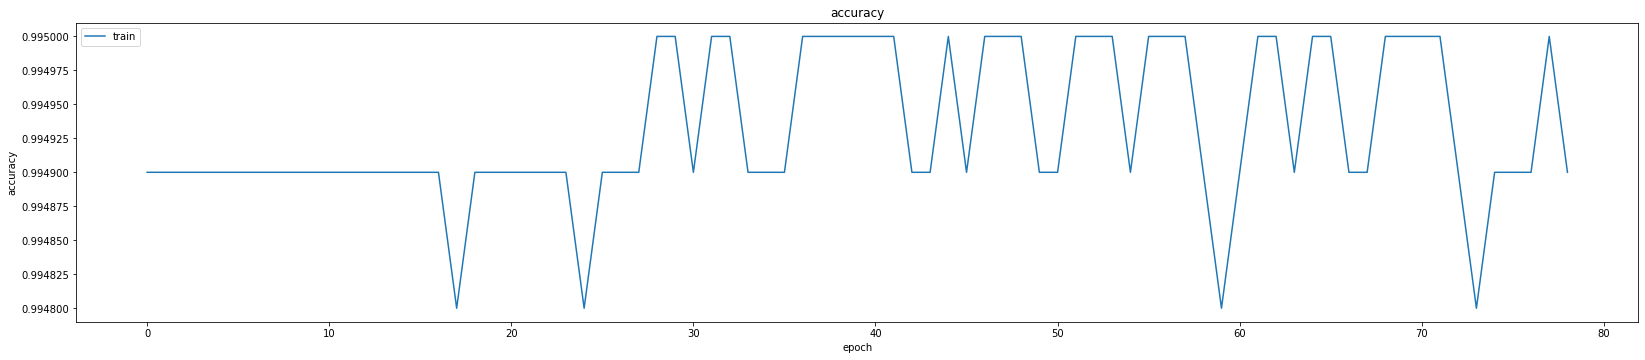

503000 513000


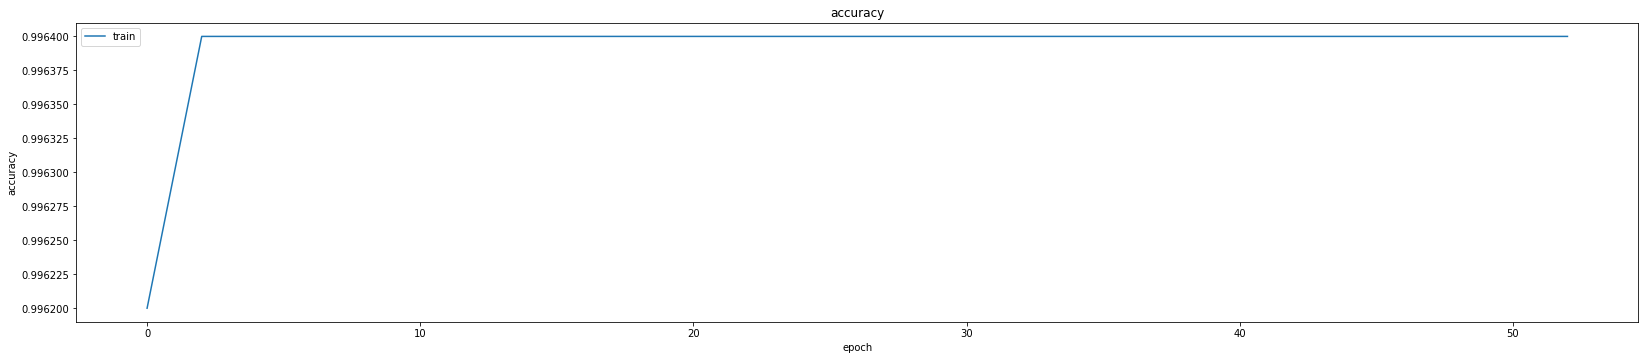

513000 523000


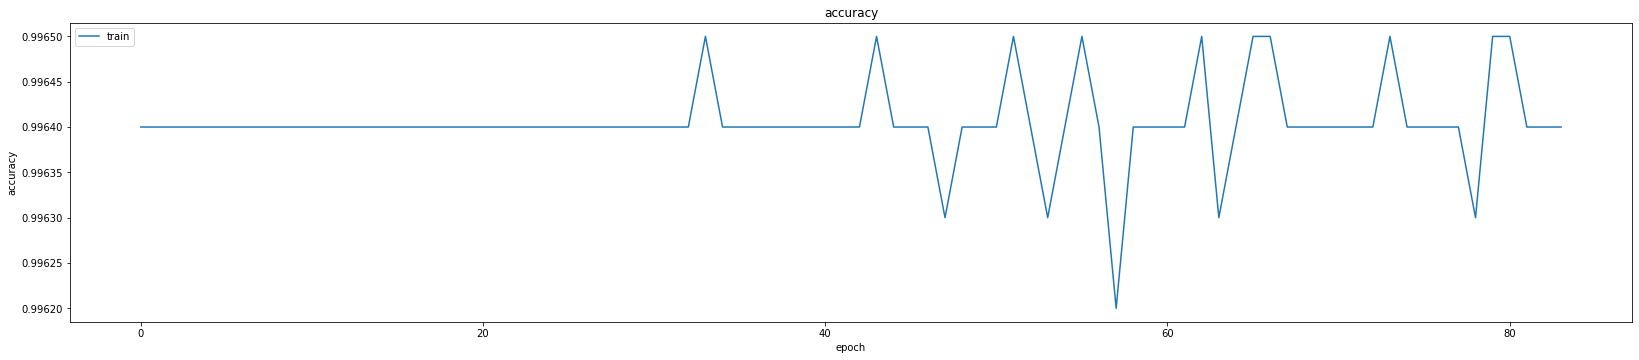

523000 533000


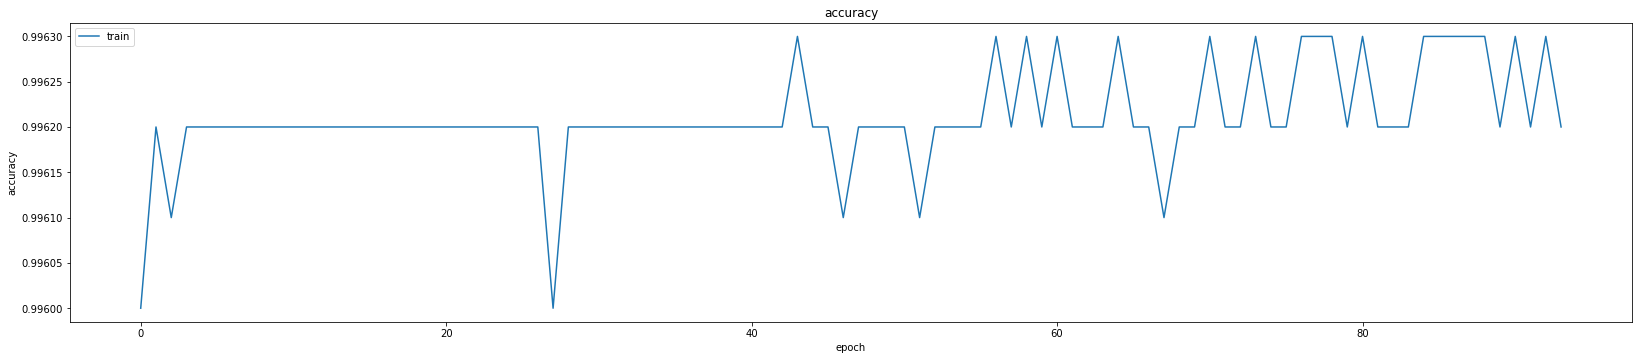

533000 543000


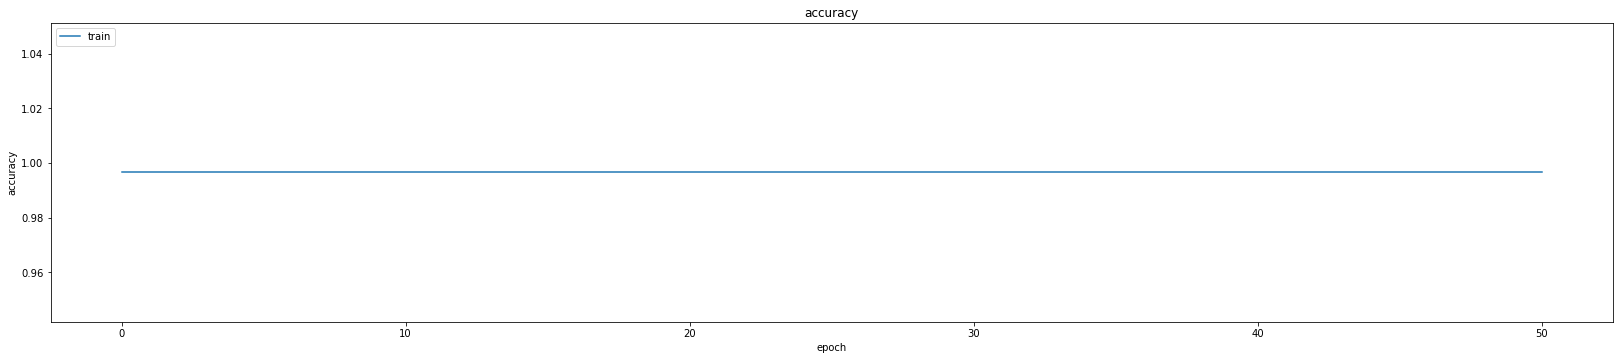

543000 553000


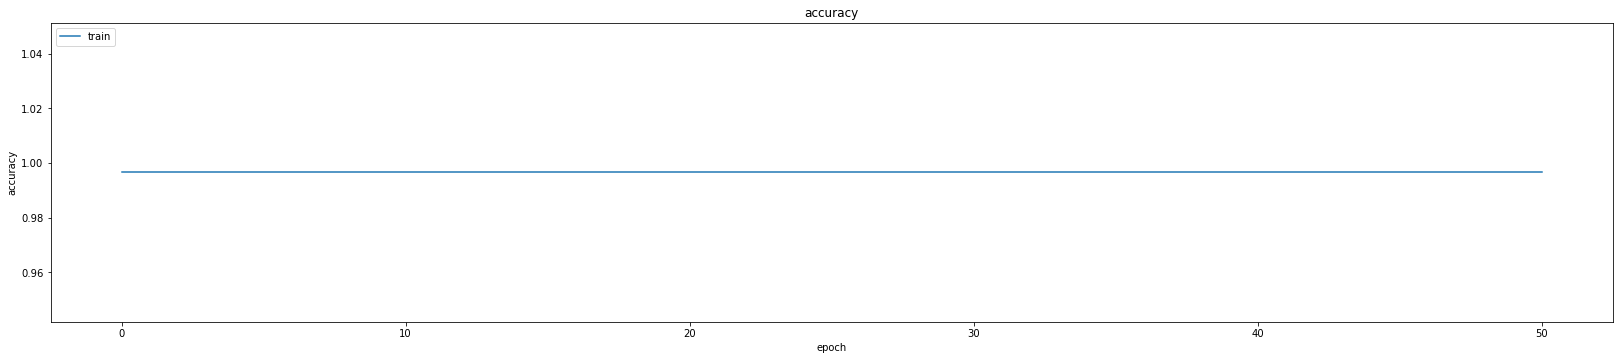

553000 563000


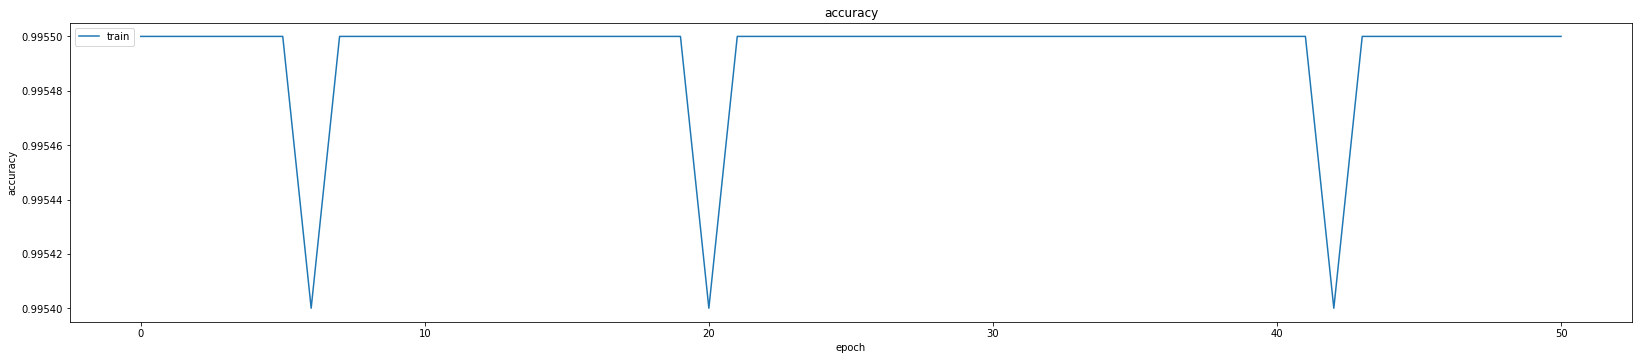

563000 573000


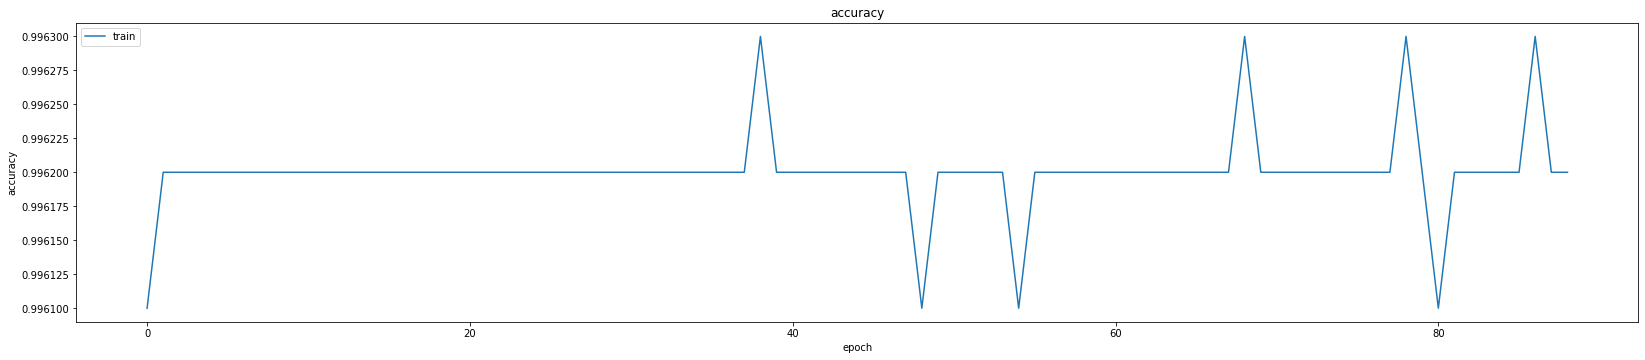

573000 583000


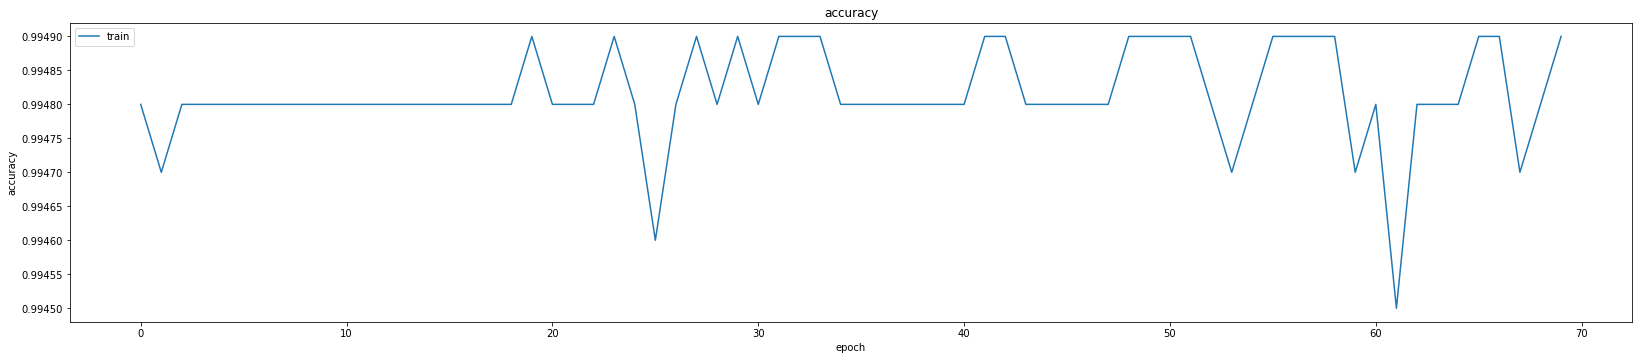

In [18]:
def plotHistory(history):
        plt.plot(history.history['accuracy'])
        plt.title('accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        
print ("Train the model")
length=len(X_train)
path_to_file="C:\\Users\\dnishimoto\\python_files\\python-deep-learning-master\\dense_equipment_model.h5"

batch_size=10000
start_pos=23000
early_stopping = EarlyStopping(monitor='accuracy', patience=50)
count=0
for index in range(start_pos,length,batch_size):
    if(index>0):
        file_exists = exists(path_to_file)
        if(file_exists):
            model.load_weights(path_to_file)
            #print("loaded weights")
        
        X2 = np.asarray(X_train[index-batch_size:index]).astype(np.float32)
        X2 = np.resize(X2,(X2.shape[0],1,X2.shape[1]))
        y2 = np.asarray(y_train[index-batch_size:index]).astype(np.float32)
        history=model.fit(X2,y2,batch_size=len(X),epochs=500,verbose=0,callbacks=[early_stopping])
        model.save_weights(path_to_file) # can give whole path to save model
        #print("saved weights")
        if (count%1000>=1):
            print(index-batch_size,index)
            plotHistory(history)
        count+=1

In [35]:
print("Random select indices from the dataframe then make a prediction")
#size=len(df)
#randomlist=[]
#for i in range(0,100):
#    n = random.randint(1,size)
#    randomlist.append(n)
#print(randomlist)

#look_back=1
#X3=df[X_columns].iloc[randomlist]
#y3=df['label'].iloc[randomlist]
#y3 = pd.get_dummies(y3)

#X3 = np.asarray(X3).astype(np.float32)
#X3 = np.resize(X3,(X3.shape[0],look_back,X3.shape[1]))
#for index,item in enumerate(y_test):
#    print(item)

X2 = np.asarray(X_test).astype(np.float32)
X2 = np.resize(X2,(X2.shape[0],1,X2.shape[1]))
y_pred=model.predict(X2)



Random select indices from the dataframe then make a prediction
9039/9039 [==============================] - 22s 2ms/step
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure 

failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure ty

failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure ty

failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure ty

failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure ty

failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure ty

failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure ty

failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure ty

failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure ty

failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure ty

failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure ty

failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure ty

failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure ty

failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure ty

failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure ty

failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure ty

failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure ty

failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure ty

failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure ty

failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure ty

failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure ty

failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure ty

failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure ty

failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure ty

failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure ty

failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure ty

failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure ty

failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure ty

failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure ty

failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure ty

failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure ty

failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure ty

failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure ty

failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure ty

failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure ty

failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure ty

failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure ty

failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure ty

failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure ty

failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure ty

failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure ty

failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure ty

failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure ty

failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure ty

failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure ty

failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure ty

failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure ty

failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure ty

failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure ty

failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure ty

failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure ty

failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure ty

failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure ty

failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure ty

failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure ty

failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure ty

failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure ty

failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure ty

failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure ty

failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure ty

failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure ty

failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure ty

failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure ty

failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure ty

failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure ty

failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure ty

failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure ty

failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure ty

failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure ty

failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure ty

failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure ty

failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure ty

failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure ty

failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure ty

failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure ty

failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure ty

failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure ty

failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure ty

failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure ty

failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure ty

failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure ty

failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure ty

failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure ty

failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure ty

failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure ty

failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure ty

failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure ty

failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure ty

failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure ty

failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure ty

failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure ty

failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure ty

failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure ty

failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure ty

failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure ty

failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure ty

failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure ty

failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure ty

failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure ty

failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure ty

failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure ty

failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure ty

failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure ty

failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure type 5
failure ty

KeyboardInterrupt: 

In [36]:
#lstfailure_types=next(iter(failure_types))
for item in y_pred:
    if np.argmax(item)!=5:
        print("failure type",np.argmax(item))

    #print(y_pred)
auc=roc_auc_score(y_test, y_pred,multi_class="ovr")
print(auc)


failure type 2
failure type 2
failure type 2
failure type 2
failure type 2
failure type 2
failure type 2
failure type 2
0.5193872174624539


In [31]:
model.summary()



Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 256)               270336    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_6 (Dense)             (None, 250)               64250     
                                                                 
 dense_7 (Dense)             (None, 250)               62750     
                                                                 
 dense_8 (Dense)             (None, 250)               62750     
                                                                 
 dense_9 (Dense)             (None, 250)               62750     
                                                                 
 dense_10 (Dense)            (None, 250)              

In [ ]:
 auc=roc_auc_score(y, predictions)